In [292]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [293]:
class SystemParameters:
    """
    All data from the paper (Table I and Figures)
    """    
    def __init__(self):
        self.K = 144                    # Number of time samples
        self.Ts = 10                    # Sample time in minutes
        self.Ts_hour = 10 / 60          # Sample time in hours
        self.hours = np.linspace(0, 24, self.K, endpoint=False)
        
        self.N_buses = 3                 # NETWORK TOPOLOGY (3-Bus Radial Feeder
        self.N_branches = 2
        self.N_stations = 3             # MESS can connect at Bus 1, 2, or 3
        # Base values
        self.S_base = 10.0              # MVA
        self.V_base = 16.0              # kV
        
        self.r = np.array([0.01, 0.015])    # Resistance (pu)
        self.x = np.array([0.02, 0.025])    # Reactance (pu)
        self.l_bar = np.array([1.5, 1.2])   # Branch thermal limits (current squared, pu)
        
        self.v_min = 0.95**2            # Minimum voltage squared (Branch Flow Model (DistFlow))
        self.v_max = 1.05**2            # Maximum voltage squaredV Branch Flow Model (DistFlow) )
        self.v_slack = 1.0              # Slack bus voltage (not squared)
        
       # Table 1 of the paper
        self.p_bar = 3.25               # Rated power (MW)
        self.E_bar = 6.381              # Rated energy (MWh)
        self.S_bar = 3.25               # Rated apparent power (MVA)
        self.eta_ch = 0.75              # Charge efficiency
        self.eta_dh = 1/0.75            # Discharge efficiency (1.33)
        self.SOC_min = 0.2              # Minimum SOC
        self.SOC_max = 0.8              # Maximum SOC
        self.SOC_init = 0.5             # Initial SOC
        self.N_cycle_max = 1.0          # Maximum daily cycles
        self.N_trips_max = 3            # Maximum daily trips
        self.V_avg = 40                 # Average truck speed (km/hr)
        self.t_ins = 5                  # Installation time (minutes)
        self.FC = 0.4                   # Fuel cost ($/km)
        self.tlc = 10                   # Labor cost ($/hr)
        
        # Distance matrix between stations (km)
        self.Dist = np.array([
            [0.0,    16.87,  19.92],
            [16.87,  0.0,    16.83],
            [19.92,  16.83,  0.0]
        ])   
        self.C_kwh = 15                # Levelized storage cost ($/MWh)
        self.C_FIT = 128                # Feed-in tariff for RES ($/MWh)
        
        self.P_load_peak = np.array([0.0, 2.0, 1.5])   # Bus 1, 2, 3 (LOAD Peak values in MW)
        self.Q_load_peak = np.array([0.0, 0.5, 0.4])   # Bus 1, 2, 3 (LOAD Peak values in MW)
        self.P_PV_rated = 0.5           # PV at Bus 2 (MW)
        self.P_WT_rated = 1.5           # Wind at Bus 3 (MW)
        # As per Table 1 of paper
        self.M = 3                      # Transit time shift limit (samples = 30 min)
        self.omega_max = 0.9            # Maximum inertia
        self.omega_min = 0.1            # Minimum inertia
        self.alpha_max = 2000           # Maximum iterations
        self.C1 = 2.0                   # Local best constant
        self.C2 = 2.0                   # Global best constant
        self.n_particles = 10           # Population size
        
    def print_summary(self):
        """Print summary of system parameters"""
        print("\n" + "="*60)
        print("SYSTEM PARAMETERS SUMMARY")
        print("="*60)
        print(f"\nTime Parameters:")
        print(f"  - Samples (K): {self.K}")
        print(f"  - Sample time: {self.Ts} minutes")
        print(f"  - Horizon: 24 hours")
        
        print(f"\nNetwork:")
        print(f"  - Buses: {self.N_buses}")
        print(f"  - Branches: {self.N_branches}")
        print(f"  - Base Power: {self.S_base} MVA")
        print(f"  - Base Voltage: {self.V_base} kV")
        
        print(f"\nMESS:")
        print(f"  - Rated Power: {self.p_bar} MW")
        print(f"  - Rated Energy: {self.E_bar} MWh")
        print(f"  - Efficiency: {self.eta_ch*100}%")
        print(f"  - SOC Range: [{self.SOC_min}, {self.SOC_max}]")
        print(f"  - Max Trips: {self.N_trips_max}")
        
        print(f"\nDistance Matrix (km):")
        print(f"  Station 1-2: {self.Dist[0,1]} km")
        print(f"  Station 1-3: {self.Dist[0,2]} km")
        print(f"  Station 2-3: {self.Dist[1,2]} km")
        print("="*60)

params = SystemParameters()
params.print_summary()


SYSTEM PARAMETERS SUMMARY

Time Parameters:
  - Samples (K): 144
  - Sample time: 10 minutes
  - Horizon: 24 hours

Network:
  - Buses: 3
  - Branches: 2
  - Base Power: 10.0 MVA
  - Base Voltage: 16.0 kV

MESS:
  - Rated Power: 3.25 MW
  - Rated Energy: 6.381 MWh
  - Efficiency: 75.0%
  - SOC Range: [0.2, 0.8]
  - Max Trips: 3

Distance Matrix (km):
  Station 1-2: 16.87 km
  Station 1-3: 19.92 km
  Station 2-3: 16.83 km


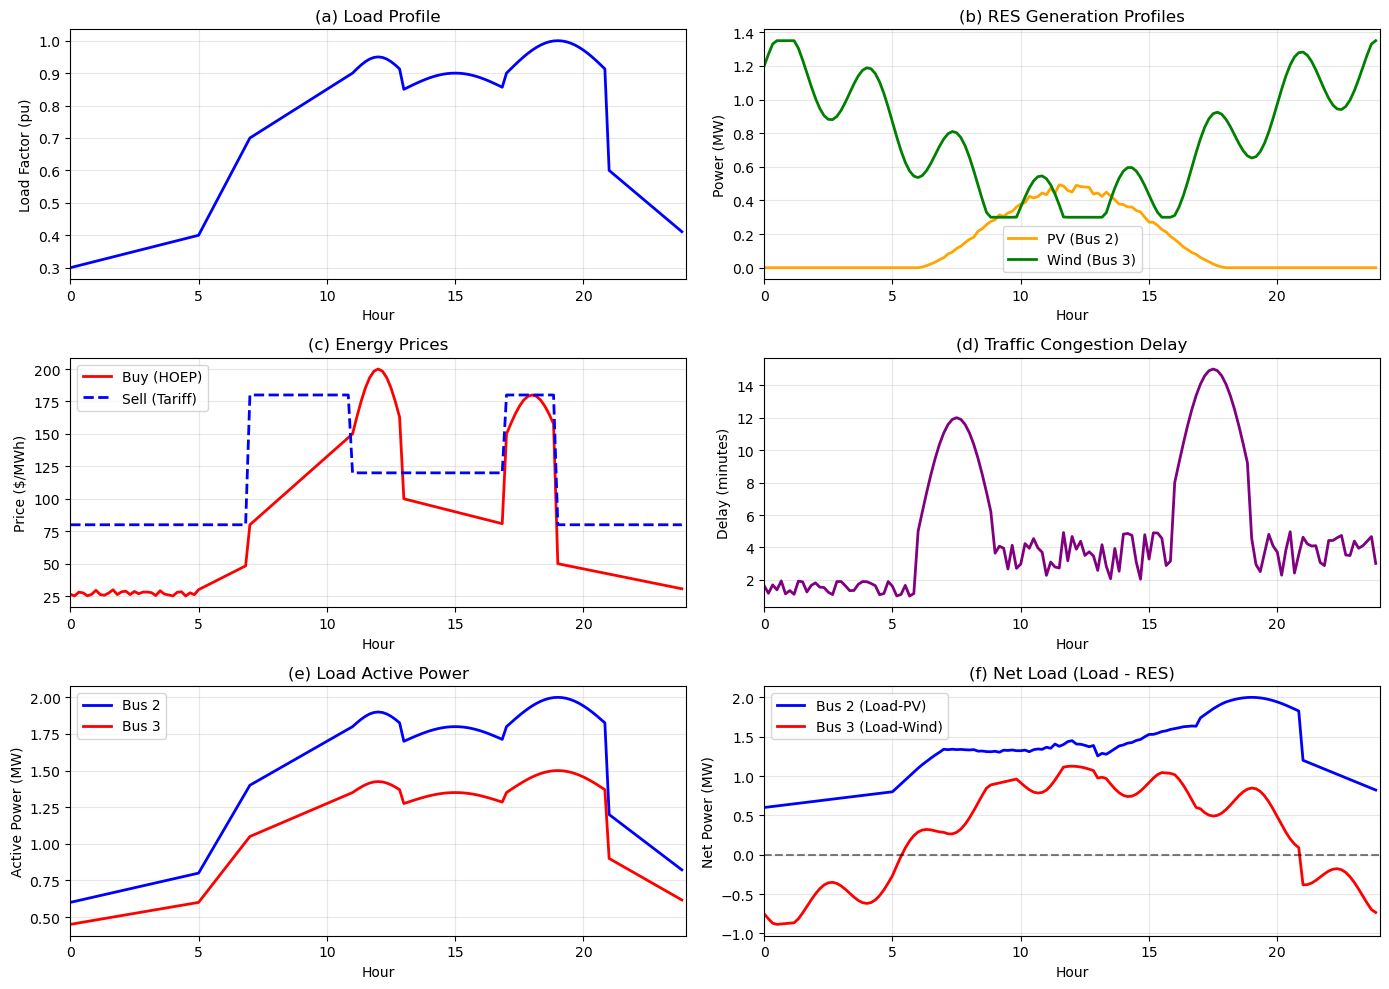


Profiles generated successfully!
  - Load peak: Bus 2 = 2.00 MW, Bus 3 = 1.50 MW
  - PV peak: 0.49 MW
  - Wind peak: 1.35 MW
  - Buy price range: [25.1, 200.0] $/MWh
  - Sell price range: [80.0, 180.0] $/MWh


In [294]:
def generate_load_profile(params: SystemParameters) -> np.ndarray:
    """
    Generate 24-hour load profile based on (Fig. 9a) of the paper
    """
    K = params.K
    hours = params.hours
    load_factor = np.zeros(K)
    
    for k in range(K):
        h = hours[k]
        if 0 <= h < 5:
            load_factor[k] = 0.3 + 0.1 * (h / 5)
        elif 5 <= h < 7:
            load_factor[k] = 0.4 + 0.3 * ((h - 5) / 2)
        elif 7 <= h < 11:
            load_factor[k] = 0.7 + 0.2 * ((h - 7) / 4)
        elif 11 <= h < 13:
            load_factor[k] = 0.9 + 0.05 * np.sin(np.pi * (h - 11) / 2)
        elif 13 <= h < 17:
            load_factor[k] = 0.85 + 0.05 * np.sin(np.pi * (h - 13) / 4)
        elif 17 <= h < 21:
            load_factor[k] = 0.9 + 0.1 * np.sin(np.pi * (h - 17) / 4)
        else:  # 21 <= h < 24
            load_factor[k] = 0.6 - 0.2 * ((h - 21) / 3)
    
    return load_factor


def generate_pv_profile(params: SystemParameters) -> np.ndarray:
    """
    Generate 24-hour PV generation profile (Fig. 9b)
    """
    K = params.K
    hours = params.hours
    pv_factor = np.zeros(K)
    
    for k in range(K):
        h = hours[k]
        if 6 <= h < 18:
            # Bell curve centered at noon
            pv_factor[k] = np.sin(np.pi * (h - 6) / 12) ** 1.5
        else:
            pv_factor[k] = 0.0
    
    # Add some variability
    pv_factor = pv_factor * (0.9 + 0.1 * np.random.rand(K))
    pv_factor = np.clip(pv_factor, 0, 1)
    
    return pv_factor


def generate_wind_profile(params: SystemParameters) -> np.ndarray:
    """
    Generate 24-hour wind generation profile (Fig. 9b)
    Wind is higher at night and lower during day
    """
    K = params.K
    hours = params.hours
    wind_factor = np.zeros(K)
    
    for k in range(K):
        h = hours[k]
        # Base wind pattern: higher at night
        base = 0.5 + 0.3 * np.cos(np.pi * h / 12)
        # Add randomness
        wind_factor[k] = base + 0.15 * np.sin(2 * np.pi * k / 20)
    
    wind_factor = np.clip(wind_factor, 0.2, 0.9)
    
    return wind_factor


def generate_price_profiles(params: SystemParameters) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate buy price (HOEP) and sell price profiles (Fig. 9c)
    """
    K = params.K
    hours = params.hours
    buy_price = np.zeros(K)
    sell_price = np.zeros(K)
    
    for k in range(K):
        h = hours[k]
        
        # Buy price (HOEP) - volatile wholesale market
        if 0 <= h < 5:
            buy_price[k] = 25 + 5 * np.random.rand()
        elif 5 <= h < 7:
            buy_price[k] = 30 + 20 * ((h - 5) / 2)
        elif 7 <= h < 11:
            buy_price[k] = 80 + 70 * ((h - 7) / 4)  # Morning peak
        elif 11 <= h < 13:
            buy_price[k] = 150 + 50 * np.sin(np.pi * (h - 11) / 2)  # Noon peak
        elif 13 <= h < 17:
            buy_price[k] = 100 - 20 * ((h - 13) / 4)
        elif 17 <= h < 19:
            buy_price[k] = 150 + 30 * np.sin(np.pi * (h - 17) / 2)  # Evening peak
        else:  # 19 <= h < 24
            buy_price[k] = 50 - 20 * ((h - 19) / 5)
        
        # Sell price (Hydro One tariff) - Time-of-Use
        if 0 <= h < 7 or 19 <= h < 24:
            sell_price[k] = 80   # Off-peak
        elif 7 <= h < 11 or 17 <= h < 19:
            sell_price[k] = 180  # On-peak
        else:
            sell_price[k] = 120  # Mid-peak
    
    return buy_price, sell_price


def generate_traffic_delay(params: SystemParameters) -> np.ndarray:
    """
    Generate traffic congestion delay profile (Fig. 9d)
    """
    K = params.K
    hours = params.hours
    traffic_delay = np.zeros(K)
    
    for k in range(K):
        h = hours[k]
        if 0 <= h < 6:
            traffic_delay[k] = 1 + np.random.rand()
        elif 6 <= h < 9:
            # Morning rush
            traffic_delay[k] = 5 + 7 * np.sin(np.pi * (h - 6) / 3)
        elif 9 <= h < 16:
            traffic_delay[k] = 2 + 3 * np.random.rand()
        elif 16 <= h < 19:
            # Evening rush
            traffic_delay[k] = 8 + 7 * np.sin(np.pi * (h - 16) / 3)
        else:
            traffic_delay[k] = 2 + 3 * np.random.rand()
    
    return traffic_delay


def generate_all_profiles(params: SystemParameters) -> Dict:
    """
    Generate all input profiles for the optimization
    """
    # Generate base profiles
    load_factor = generate_load_profile(params)
    pv_factor = generate_pv_profile(params)
    wind_factor = generate_wind_profile(params)
    buy_price, sell_price = generate_price_profiles(params)
    traffic_delay = generate_traffic_delay(params)
    
    # Calculate actual load powers (MW)
    P_load = np.zeros((params.N_buses, params.K))
    Q_load = np.zeros((params.N_buses, params.K))
    
    for k in range(params.K):
        P_load[:, k] = params.P_load_peak * load_factor[k]
        Q_load[:, k] = params.Q_load_peak * load_factor[k]
    
    # Calculate RES generation (MW)
    P_PV = params.P_PV_rated * pv_factor      # At Bus 2
    P_WT = params.P_WT_rated * wind_factor    # At Bus 3
    
    profiles = {
        'load_factor': load_factor,
        'P_load': P_load,           # Shape: (3, K)
        'Q_load': Q_load,           # Shape: (3, K)
        'P_PV': P_PV,               # Shape: (K,)
        'P_WT': P_WT,               # Shape: (K,)
        'buy_price': buy_price,     # Shape: (K,)
        'sell_price': sell_price,   # Shape: (K,)
        'traffic_delay': traffic_delay  # Shape: (K,)
    }
    
    return profiles


# Generate profiles
profiles = generate_all_profiles(params)

# Plot all profiles
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Load profile
axes[0, 0].plot(params.hours, profiles['load_factor'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Load Factor (pu)')
axes[0, 0].set_title('(a) Load Profile')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 24])

# RES profiles
axes[0, 1].plot(params.hours, profiles['P_PV'], 'orange', linewidth=2, label='PV (Bus 2)')
axes[0, 1].plot(params.hours, profiles['P_WT'], 'green', linewidth=2, label='Wind (Bus 3)')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Power (MW)')
axes[0, 1].set_title('(b) RES Generation Profiles')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 24])

# Price profiles
axes[1, 0].plot(params.hours, profiles['buy_price'], 'r-', linewidth=2, label='Buy (HOEP)')
axes[1, 0].plot(params.hours, profiles['sell_price'], 'b--', linewidth=2, label='Sell (Tariff)')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Price ($/MWh)')
axes[1, 0].set_title('(c) Energy Prices')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 24])

# Traffic delay
axes[1, 1].plot(params.hours, profiles['traffic_delay'], 'purple', linewidth=2)
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Delay (minutes)')
axes[1, 1].set_title('(d) Traffic Congestion Delay')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 24])

# Load at each bus
axes[2, 0].plot(params.hours, profiles['P_load'][1, :], 'b-', linewidth=2, label='Bus 2')
axes[2, 0].plot(params.hours, profiles['P_load'][2, :], 'r-', linewidth=2, label='Bus 3')
axes[2, 0].set_xlabel('Hour')
axes[2, 0].set_ylabel('Active Power (MW)')
axes[2, 0].set_title('(e) Load Active Power')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim([0, 24])

# Net load (Load - RES)
net_load_bus2 = profiles['P_load'][1, :] - profiles['P_PV']
net_load_bus3 = profiles['P_load'][2, :] - profiles['P_WT']
axes[2, 1].plot(params.hours, net_load_bus2, 'b-', linewidth=2, label='Bus 2 (Load-PV)')
axes[2, 1].plot(params.hours, net_load_bus3, 'r-', linewidth=2, label='Bus 3 (Load-Wind)')
axes[2, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[2, 1].set_xlabel('Hour')
axes[2, 1].set_ylabel('Net Power (MW)')
axes[2, 1].set_title('(f) Net Load (Load - RES)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_xlim([0, 24])

plt.tight_layout()
plt.savefig('input_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nProfiles generated successfully!")
print(f"  - Load peak: Bus 2 = {profiles['P_load'][1,:].max():.2f} MW, Bus 3 = {profiles['P_load'][2,:].max():.2f} MW")
print(f"  - PV peak: {profiles['P_PV'].max():.2f} MW")
print(f"  - Wind peak: {profiles['P_WT'].max():.2f} MW")
print(f"  - Buy price range: [{profiles['buy_price'].min():.1f}, {profiles['buy_price'].max():.1f}] $/MWh")
print(f"  - Sell price range: [{profiles['sell_price'].min():.1f}, {profiles['sell_price'].max():.1f}] $/MWh")

In [295]:
def calculate_power_flow_paper(params: SystemParameters,
                                profiles: Dict,
                                P_mess: float,
                                Q_mess: float,
                                station: int,
                                k: int) -> Dict:
    """
    Calculate power flow for 3-bus radial feeder using EXACT paper equations
    """
    # Define power injections at each bus
    
    # Active power components (MW)
    P_load = np.array([0.0, 
                       profiles['P_load'][1, k], 
                       profiles['P_load'][2, k]])
    
    P_gen = np.array([0.0, 0.0, 0.0])  # No conventional generators
    
    P_res = np.array([0.0,
                      profiles['P_PV'][k],      # PV at Bus 2
                      profiles['P_WT'][k]])     # Wind at Bus 3
    
    P_mess_bus = np.array([0.0, 0.0, 0.0])
    P_mess_bus[station] = P_mess  # Positive = charging (load)
    
    # Reactive power components (MVAR)
    Q_load = np.array([0.0,
                       profiles['Q_load'][1, k],
                       profiles['Q_load'][2, k]])
    
    Q_gen = np.array([0.0, 0.0, 0.0])
    
    Q_mess_bus = np.array([0.0, 0.0, 0.0])
    Q_mess_bus[station] = Q_mess
       
    # Branch impedances (pu)
    r = params.r  # [r_1, r_2]
    x = params.x  # [x_1, x_2]
    
    # Voltage squared (start with flat voltage)
    v = np.array([1.0, 1.0, 1.0])  # v = V² in pu
    
    # Branch power flows (will be calculated)
    p = np.zeros(2)  # [p_1, p_2] - active power on branches
    q = np.zeros(2)  # [q_1, q_2] - reactive power on branches
    ell = np.zeros(2)  # [ℓ_1, ℓ_2] - current squared (I²)
    
    # STEP 3: Iterative Power Flow Solution (Backward-Forward Sweep)
    max_iter = 20
    tolerance = 1e-6
    
    for iteration in range(max_iter):
        v_old = v.copy()
        
        # BACKWARD SWEEP: Calculate branch power flows (Eqs. 8-9)
        # From Eq. 8 for branch 2 (feeding bus 3):
        p[1] = P_load[2] + P_mess_bus[2] - P_gen[2] - P_res[2]
        q[1] = Q_load[2] + Q_mess_bus[2] - Q_gen[2]
        
        # Current squared on Branch 2 (from Eq. 11)
        # ℓ_2 * v_2 = p_2² + q_2²  =>  ℓ_2 = (p_2² + q_2²) / v_2
        ell[1] = (p[1]**2 + q[1]**2) / (v[1] * params.S_base**2 + 1e-6)

        # From Eq. 8 for branch 1 (feeding bus 2, with branch 2 downstream):
        p[0] = P_load[1] + P_mess_bus[1] - P_gen[1] - P_res[1] + (p[1] + r[1] * ell[1] * params.S_base)
        q[0] = Q_load[1] + Q_mess_bus[1] - Q_gen[1] + (q[1] + x[1] * ell[1] * params.S_base)
        # Current squared on Branch 1 (from Eq. 11)
        ell[0] = (p[0]**2 + q[0]**2) / (v[0] * params.S_base**2 + 1e-6)

        v[0] = 1.0  # V² = 1.0 pu
        
        # FORWARD SWEEP: Calculate bus voltages (Eq. 10)
        # Bus 2
        # v_2 = v_1 - 2(r_1 * p_1 + x_1 * q_1) + (r_1² + x_1²) * ℓ_1
        v[1] = v[0] - 2 * (r[0] * p[0] + x[0] * q[0]) / params.S_base + \
               (r[0]**2 + x[0]**2) * ell[0]
        # Bus 3
        # v_3 = v_2 - 2(r_2 * p_2 + x_2 * q_2) + (r_2² + x_2²) * ℓ_2
        v[2] = v[1] - 2 * (r[1] * p[1] + x[1] * q[1]) / params.S_base + \
               (r[1]**2 + x[1]**2) * ell[1]
        
        # Ensure voltage stays positive (numerical stability)
        v = np.maximum(v, 0.81)  # V² > 0.81 means V > 0.9
        
        # Check convergence
        if np.max(np.abs(v - v_old)) < tolerance:
            break
    
    #Calculate power losses (Eq. 14)
    # loss_k = Σ r_t * ℓ_tk
    P_loss = r[0] * ell[0] * params.S_base + r[1] * ell[1] * params.S_base  # MW
    
    # Calculate grid power (Power from slack bus)
    # From Eq. 6 at Bus 1: P_g1 = p_1 - r_1 * ℓ_1 (power leaving bus 1)
    P_grid = p[0]  # MW
    Q_grid = q[0]  # MVAR
    
  
    # Check SOCP constraint (Eq. 35)
    # ||[2p_t, 2q_t, ℓ_t - v_a]||_2 <= ℓ_t + v_a
    
    socp_1 = np.sqrt((2*p[0])**2 + (2*q[0])**2 + (ell[0]*params.S_base**2 - v[0])**2)
    socp_1_limit = ell[0]*params.S_base**2 + v[0]
    socp_1_ok = socp_1 <= socp_1_limit + 0.01
    
    socp_2 = np.sqrt((2*p[1])**2 + (2*q[1])**2 + (ell[1]*params.S_base**2 - v[1])**2)
    socp_2_limit = ell[1]*params.S_base**2 + v[1]
    socp_2_ok = socp_2 <= socp_2_limit + 0.01
    

    # Check constraints 

   
    v_min_sq = params.v_min  # 0.95² = 0.9025                                           # Voltage limits (Eq. 16): v_min <= v_bk <= v_max
    v_max_sq = params.v_max  # 1.05² = 1.1025
    
    voltage_ok = (v[1] >= v_min_sq - 0.01) and (v[1] <= v_max_sq + 0.01) and \
                 (v[2] >= v_min_sq - 0.01) and (v[2] <= v_max_sq + 0.01)
    
   
    thermal_ok = (ell[0] <= params.l_bar[0]) and (ell[1] <= params.l_bar[1])         # Thermal limits (Eq. 15): ℓ_tk <= ℓ̄_t
    
 
    V_magnitude = np.sqrt(np.maximum(v, 0))                                         # Convert V² to V for output
       
    return {
        'P_grid': P_grid,
        'Q_grid': Q_grid,
        'p_branch': p.copy(),           # Branch active power (MW)
        'q_branch': q.copy(),           # Branch reactive power (MVAR)
        'ell': ell.copy(),              # Current squared (pu)
        'v_squared': v.copy(),          # Voltage squared (pu)
        'V': V_magnitude,               # Voltage magnitude (pu)
        'P_loss': P_loss,               # Total losses (MW)
        'P_loss_branch': np.array([r[0]*ell[0]*params.S_base, 
                                   r[1]*ell[1]*params.S_base]),  # Per-branch losses
        'iterations': iteration + 1,
        'socp_ok': socp_1_ok and socp_2_ok,
        'voltage_ok': voltage_ok,
        'thermal_ok': thermal_ok,
        'feasible': voltage_ok and thermal_ok,
        # Debug info
        'P_load': P_load,
        'P_res': P_res,
        'P_mess_bus': P_mess_bus
    }


def calculate_power_flow_no_mess_paper(params: SystemParameters, 
                                        profiles: Dict,
                                        k: int) -> Dict:
    """Power flow without MESS using paper equations"""
    return calculate_power_flow_paper(params, profiles, 0.0, 0.0, 0, k)


# Wrapper for compatibility
def calculate_power_flow(params, profiles, P_mess, Q_mess, station, k):
    """Wrapper that uses paper's equations"""
    return calculate_power_flow_paper(params, profiles, P_mess, Q_mess, station, k)


def calculate_power_flow_no_mess(params, profiles, k):
    """Wrapper that uses paper's equations"""
    return calculate_power_flow_no_mess_paper(params, profiles, k)

In [296]:
def calculate_soc_dynamics(params: SystemParameters,
                           SOC_current: float,
                           P_ch: float,
                           P_dh: float) -> float:
    """
    Calculate next SOC based on charge/discharge power (Eq. 37)
    
    SOC_{k+1} = SOC_k + (Ts/E_bar) * (eta_ch * P_ch + eta_dh * P_dh)
    
    Args:
        params: System parameters
        SOC_current: Current state of charge [0, 1]
        P_ch: Charge power (>= 0) in MW
        P_dh: Discharge power (<= 0) in MW
    
    Returns:
        SOC_next: Next state of charge
    """
    delta_SOC = (params.Ts_hour / params.E_bar) * (params.eta_ch * P_ch + (1/params.eta_dh) * P_dh)
    SOC_next = SOC_current + delta_SOC
    
    return SOC_next


def calculate_cycle_dynamics(params: SystemParameters,
                             N_current: float,
                             P_ch: float,
                             P_dh: float) -> float:
    """
    Calculate next number of cycles (Eq. 38)
    N_{k+1} = N_k + (Ts / 2*E_bar) * (eta_ch * P_ch - eta_dh * P_dh)
    """
    # Note: P_dh is negative, so -P_dh is positive when discharging
    delta_N = (params.Ts_hour / (2 * params.E_bar)) * (params.eta_ch * P_ch - (1/params.eta_dh) * P_dh)
    N_next = N_current + delta_N
    
    return N_next


def check_ess_constraints(params: SystemParameters,
                          SOC: float,
                          N_cycle: float,
                          P_ch: float,
                          P_dh: float,
                          Q: float,
                          z: int) -> bool:
    """
    Check all ESS constraints (Eqs. 39-41, 22-24)
    """
    # Power limits (Eqs. 39-40)
    if P_ch < 0 or P_ch > params.p_bar * z:
        return False
    if P_dh > 0 or P_dh < -params.p_bar * z:
        return False
    
    # Reactive power limit (Eq. 41)
    if abs(Q) > params.S_bar * z:
        return False
    
    # Apparent power limit (Eq. 22)
    P_total = P_ch + P_dh
    if P_total**2 + Q**2 > params.S_bar**2:
        return False
    
    # SOC limits (Eq. 23)
    if SOC < params.SOC_min or SOC > params.SOC_max:
        return False
    
    return True


def discretize_soc(SOC: float, n_levels: int = 21) -> int:
   
    soc_idx = int(round(SOC * (n_levels - 1)))
    soc_idx = max(0, min(n_levels - 1, soc_idx))
    return soc_idx


def continuous_soc(soc_idx: int, n_levels: int = 21) -> float:
   
    return soc_idx / (n_levels - 1)


# Test ESS dynamics
print("Testing ESS Dynamics...")
print("="*60)

SOC_test = 0.5
P_ch_test = 2.0  # MW charging
P_dh_test = 0.0  # No discharge

SOC_next = calculate_soc_dynamics(params, SOC_test, P_ch_test, P_dh_test)
print(f"\nCharging Test:")
print(f"  Current SOC: {SOC_test:.3f}")
print(f"  Charge Power: {P_ch_test} MW")
print(f"  Next SOC: {SOC_next:.3f}")
print(f"  Delta SOC: {SOC_next - SOC_test:.4f}")

P_ch_test = 0.0
P_dh_test = -2.0  # MW discharging

SOC_next = calculate_soc_dynamics(params, SOC_test, P_ch_test, P_dh_test)
print(f"\nDischarging Test:")
print(f"  Current SOC: {SOC_test:.3f}")
print(f"  Discharge Power: {P_dh_test} MW")
print(f"  Next SOC: {SOC_next:.3f}")
print(f"  Delta SOC: {SOC_next - SOC_test:.4f}")

# Calculate time to fully charge/discharge
time_to_full_charge = (params.SOC_max - params.SOC_min) * params.E_bar / (params.eta_ch * params.p_bar)
time_to_full_discharge = (params.SOC_max - params.SOC_min) * params.E_bar / (params.p_bar / params.eta_dh)

print(f"\nCharging/Discharging Times:")
print(f"  Time to full charge (20%→100%): {time_to_full_charge:.2f} hours")
print(f"  Time to full discharge (100%→20%): {time_to_full_discharge:.2f} hours")

Testing ESS Dynamics...

Charging Test:
  Current SOC: 0.500
  Charge Power: 2.0 MW
  Next SOC: 0.539
  Delta SOC: 0.0392

Discharging Test:
  Current SOC: 0.500
  Discharge Power: -2.0 MW
  Next SOC: 0.461
  Delta SOC: -0.0392

Charging/Discharging Times:
  Time to full charge (20%→100%): 1.57 hours
  Time to full discharge (100%→20%): 1.57 hours


In [297]:
def calculate_transit_time(params: SystemParameters,
                           profiles: Dict,
                           station_from: int,
                           station_to: int,
                           k: int) -> int:
    """
    Calculate transit time in samples (Eq. 2)
    
    tau_ijk = round((tc_ijk + d_ij/V_avg + t_ins) / Ts)
    """
    if station_from == station_to:
        return 0
    
    # Distance between stations (km)
    d_ij = params.Dist[station_from, station_to]
    
    # Traffic congestion delay (minutes)
    tc_ijk = profiles['traffic_delay'][k]
    
    # Travel time (minutes)
    travel_time = (d_ij / params.V_avg) * 60  # Convert hours to minutes
    
    # Total transit time (minutes)
    total_time = tc_ijk + travel_time + params.t_ins
    
    # Convert to samples
    tau = int(np.round(total_time / params.Ts))
    
    return max(1, tau)  # At least 1 sample


def generate_transit_matrix(params: SystemParameters,
                            profiles: Dict) -> np.ndarray:
    """
    Generate transit time matrix for all station pairs and times
    
    Returns:
        tau: Array of shape (N_stations, N_stations, K) with transit times in samples
    """
    tau = np.zeros((params.N_stations, params.N_stations, params.K), dtype=int)
    
    for i in range(params.N_stations):
        for j in range(params.N_stations):
            for k in range(params.K):
                tau[i, j, k] = calculate_transit_time(params, profiles, i, j, k)
    
    return tau


def get_transit_set(params: SystemParameters,
                    Z: np.ndarray,
                    tau: np.ndarray) -> List[Tuple[int, int]]:
    """
    Get the transit set N_tau from station schedule Z (Eq. 43)
    """
    N_tau = []
    
    for k in range(1, params.K):
        # Find current and previous station
        station_prev = np.argmax(Z[:, k-1])
        station_curr = np.argmax(Z[:, k])
        
        if station_prev != station_curr:
            # MESS moved from station_prev to station_curr
            transit_time = tau[station_prev, station_curr, k-1]
            transit_start = k - 1
            transit_end = min(k - 1 + transit_time, params.K - 1)
            N_tau.append((transit_start, transit_end))
    
    return N_tau


def is_in_transit(k: int, N_tau: List[Tuple[int, int]]) -> bool:
    """
    Check if time k is in any transit period
    """
    for start, end in N_tau:
        if start <= k <= end:
            return True
    return False


# Generate transit matrix
tau_matrix = generate_transit_matrix(params, profiles)

print("Transit Time Matrix Generated")
print("="*60)
print("\nTransit times (samples) at different hours:")
print("\nFrom Station 1 to other stations:")
for k_test in [0, 48, 72, 96]:
    print(f"  k={k_test} ({params.hours[k_test]:.1f}h): to S2={tau_matrix[0,1,k_test]}, to S3={tau_matrix[0,2,k_test]}")

print("\nFrom Station 2 to other stations:")
for k_test in [0, 48, 72, 96]:
    print(f"  k={k_test} ({params.hours[k_test]:.1f}h): to S1={tau_matrix[1,0,k_test]}, to S3={tau_matrix[1,2,k_test]}")

print("\nFrom Station 3 to other stations:")
for k_test in [0, 48, 72, 96]:
    print(f"  k={k_test} ({params.hours[k_test]:.1f}h): to S1={tau_matrix[2,0,k_test]}, to S2={tau_matrix[2,1,k_test]}")

Transit Time Matrix Generated

Transit times (samples) at different hours:

From Station 1 to other stations:
  k=0 (0.0h): to S2=3, to S3=4
  k=48 (8.0h): to S2=4, to S3=5
  k=72 (12.0h): to S2=3, to S3=4
  k=96 (16.0h): to S2=4, to S3=4

From Station 2 to other stations:
  k=0 (0.0h): to S1=3, to S3=3
  k=48 (8.0h): to S1=4, to S3=4
  k=72 (12.0h): to S1=3, to S3=3
  k=96 (16.0h): to S1=4, to S3=4

From Station 3 to other stations:
  k=0 (0.0h): to S1=4, to S2=3
  k=48 (8.0h): to S1=5, to S2=4
  k=72 (12.0h): to S1=4, to S2=3
  k=96 (16.0h): to S1=4, to S2=4


In [298]:
def calculate_grid_cost(params: SystemParameters,
                        profiles: Dict,
                        P_grid: np.ndarray) -> float:
    """
    Calculate grid energy cost (Eq. 30)
    
    C_grid = sum_k (Ts * BP_k * P_grid_k)
    
    Only count POSITIVE grid power (import from grid)
    Negative grid power means export (could be income or curtailment)
    
    Args:
        params: System parameters
        profiles: Input profiles
        P_grid: Grid power at each time step (MW) - positive = import
    
    Returns:
        C_grid: Grid cost in $
    """
    C_grid = 0.0
    for k in range(params.K):
        if P_grid[k] > 0:
            # Importing from grid - this is a cost
            C_grid += params.Ts_hour * profiles['buy_price'][k] * P_grid[k]
        else:
            # Exporting to grid - could sell at lower price or curtail
            # For simplicity, assume we can sell excess at 50% of buy price
            C_grid += params.Ts_hour * profiles['buy_price'][k] * 0.5 * P_grid[k]
    
    return C_grid


def calculate_income(params: SystemParameters,
                     profiles: Dict) -> float:
    """
    Calculate income from selling energy to loads (Eq. 31)
    
    inc = sum_k sum_l (Ts * SP_k * P_lk)
    
    Args:
        params: System parameters
        profiles: Input profiles
    
    Returns:
        income: Income in $
    """
    income = 0.0
    for k in range(params.K):
        # Total load at buses 2 and 3
        total_load = profiles['P_load'][1, k] + profiles['P_load'][2, k]
        income += params.Ts_hour * profiles['sell_price'][k] * total_load
    
    return income


def calculate_mess_cost(params: SystemParameters,
                        P_ch: np.ndarray,
                        P_dh: np.ndarray,
                        n_trips: int) -> Tuple[float, float, float]:
    """
    Calculate MESS operating cost (Eqs. 27-29) - PAPER'S ORIGINAL VALUES
    """   
    # =========================================================================
    # TRUCK COST (Eq. 28)
    # C_truck = FC × N_trip × max(Dist) + tlc
    # =========================================================================
    
    if n_trips > 0 or np.any(P_ch > 0) or np.any(P_dh < 0):
        # Fuel cost: FC × N_trips × max(Dist)
        fuel_cost = params.FC * n_trips * np.max(params.Dist)
        
        # Labor cost: tlc (25 $/hr × 24 hr) - PAPER'S VALUE
        labor_cost = params.tlc * 8 
        
        C_truck = fuel_cost + labor_cost
    else:
        C_truck = 0   
    # =========================================================================
    # ESS COST (Eq. 29)
    # C_ess = sum_k sum_s (P_ch_sk × Ts × C_kwh)
    # =========================================================================
    
    # Using paper's levelized cost: C_kwh = 221 $/MWh
    C_ess = 0.0
    for k in range(len(P_ch)):
        if P_ch[k] > 0:
            # Only charged energy contributes to ESS cost (as per Eq. 29)
            C_ess += P_ch[k] * params.Ts_hour * params.C_kwh  # 221 $/MWh
    
    # =========================================================================
    # TOTAL MESS COST (Eq. 27)
    # =========================================================================
    C_mess = C_truck + C_ess
    
    return C_mess, C_truck, C_ess




def calculate_res_cost(params: SystemParameters,
                       profiles: Dict) -> float:
    """
    Calculate RES cost (FIT payments) (Eq. 26)
    """
    C_res = 0.0
    for k in range(params.K):
        C_res += (profiles['P_PV'][k] + profiles['P_WT'][k]) * params.Ts_hour * params.C_FIT    
    return C_res

def calculate_profit(params: SystemParameters,
                     profiles: Dict,
                     P_grid: np.ndarray,
                     P_ch: np.ndarray,
                     P_dh: np.ndarray,
                     n_trips: int) -> Dict:
    """
    Calculate total profit (Eq. 32)
    pro = inc - C_grid - C_mess - C_res
    """
    income = calculate_income(params, profiles)
    C_grid = calculate_grid_cost(params, profiles, P_grid)
    C_mess, C_truck, C_ess = calculate_mess_cost(params, P_ch, P_dh, n_trips)
    C_res = calculate_res_cost(params, profiles)
    
    profit = income - C_grid - C_mess - C_res
    
    return {
        'income': income,
        'C_grid': C_grid,
        'C_mess': C_mess,
        'C_truck': C_truck,
        'C_ess': C_ess,
        'C_res': C_res,
        'profit': profit
    }


# Test with paper's values
print("Testing with PAPER'S ORIGINAL Cost Parameters...")
print("="*60)
print(f"\nPaper's Parameters:")
print(f"  FC (fuel cost): {params.FC} $/km")
print(f"  tlc (labor): {params.tlc} $/hr × 24 hr = ${params.tlc * 24}/day")
print(f"  C_kwh (ESS levelized): {params.C_kwh} $/MWh")
print(f"  max(Dist): {np.max(params.Dist):.2f} km")

# Calculate example costs
print(f"\nExample MESS Cost Calculation (2 trips, 5 MWh charged):")
fuel = params.FC * 2 * np.max(params.Dist)
labor = params.tlc * 24
ess = 5 * params.C_kwh
print(f"  Truck Fuel: {params.FC} × 2 × {np.max(params.Dist):.2f} = ${fuel:.2f}")
print(f"  Truck Labor: {params.tlc} × 24 = ${labor:.2f}")
print(f"  ESS Cost: 5 MWh × {params.C_kwh} = ${ess:.2f}")
print(f"  Total MESS Cost: ${fuel + labor + ess:.2f}")

# Test without MESS
P_grid_no_mess = np.zeros(params.K)
for k in range(params.K):
    pf = calculate_power_flow_no_mess(params, profiles, k)
    P_grid_no_mess[k] = pf['P_grid']

P_ch_zero = np.zeros(params.K)
P_dh_zero = np.zeros(params.K)
profit_no_mess = calculate_profit(params, profiles, P_grid_no_mess, P_ch_zero, P_dh_zero, 0)

print(f"\n" + "="*60)
print("Costs WITHOUT MESS:")
print(f"  Income: ${profit_no_mess['income']:.2f}")
print(f"  Grid Cost: ${profit_no_mess['C_grid']:.2f}")
print(f"  RES Cost: ${profit_no_mess['C_res']:.2f}")
print(f"  MESS Cost: ${profit_no_mess['C_mess']:.2f}")
print(f"  Net Profit: ${profit_no_mess['profit']:.2f}")


Testing with PAPER'S ORIGINAL Cost Parameters...

Paper's Parameters:
  FC (fuel cost): 0.4 $/km
  tlc (labor): 10 $/hr × 24 hr = $240/day
  C_kwh (ESS levelized): 15 $/MWh
  max(Dist): 19.92 km

Example MESS Cost Calculation (2 trips, 5 MWh charged):
  Truck Fuel: 0.4 × 2 × 19.92 = $15.94
  Truck Labor: 10 × 24 = $240.00
  ESS Cost: 5 MWh × 15 = $75.00
  Total MESS Cost: $330.94

Costs WITHOUT MESS:
  Income: $7233.60
  Grid Cost: $3946.34
  RES Cost: $2752.32
  MESS Cost: $0.00
  Net Profit: $534.94


In [299]:
def stage1_forward_optimization(params: SystemParameters,
                                 profiles: Dict) -> Dict:
    """
    Stage 1: Forward Optimization for MESS Scheduling
    """
    print("\n" + "="*60)
    print("STAGE 1: Forward Optimization with MESS Movement")
    print("="*60)
    
    K = params.K
    N_stations = params.N_stations
    
    # Initialize arrays
    Z = np.zeros((N_stations, K), dtype=int)
    P_mess = np.zeros(K)
    P_ch_arr = np.zeros(K)
    P_dh_arr = np.zeros(K)
    Q_mess = np.zeros(K)
    SOC_trajectory = np.zeros(K + 1)
    N_cycle = np.zeros(K + 1)
    P_grid_arr = np.zeros(K)
    V_arr = np.zeros((3, K))
    P_loss_arr = np.zeros(K)  # Track losses
    
    # Initial conditions
    SOC_trajectory[0] = params.SOC_init
    N_cycle[0] = 0
    current_SOC = params.SOC_init
    current_cycles = 0
    
    # =========================================================================
    # PRICE ANALYSIS - Find optimal charge/discharge periods
    # =========================================================================
    
    buy_price = profiles['buy_price']
    
    # Sort prices to find cheapest and most expensive hours
    price_sorted_idx = np.argsort(buy_price)
    
    # Cheapest 25% of hours -> CHARGE
    n_cheap = K // 4
    cheap_hours = set(price_sorted_idx[:n_cheap])
    
    # Most expensive 25% of hours -> DISCHARGE  
    n_expensive = K // 4
    expensive_hours = set(price_sorted_idx[-n_expensive:])
    
    # Calculate thresholds
    cheap_threshold = np.percentile(buy_price, 25)
    expensive_threshold = np.percentile(buy_price, 75)
    
    print(f"\nPrice Analysis:")
    print(f"  Min price: ${buy_price.min():.1f}/MWh")
    print(f"  Max price: ${buy_price.max():.1f}/MWh")
    print(f"  25th percentile (charge below): ${cheap_threshold:.1f}/MWh")
    print(f"  75th percentile (discharge above): ${expensive_threshold:.1f}/MWh")
    
    # =========================================================================
    # STATION SELECTION LOGIC
    # =========================================================================
    
    def select_station_for_charging(k):
        """Select best station for charging at time k"""
        pv = profiles['P_PV'][k]
        wind = profiles['P_WT'][k]
        load3 = profiles['P_load'][2, k]
        
        # Net surplus at Bus 3
        net_wind = wind - load3
        
        if net_wind > 0.3:  # True local surplus at Bus 3
            return 2  # Station 3 - absorb local surplus
        elif pv > 0.2:
            return 1  # Station 2 - use local PV
        else:
            return 0  # Station 1 - closest to grid (minimum losses!)
    
    def select_station_for_discharging(k):
        """Select best station for discharging at time k"""
        load2 = profiles['P_load'][1, k]
        load3 = profiles['P_load'][2, k]
        pv = profiles['P_PV'][k]
        wind = profiles['P_WT'][k]
        
        net_load2 = load2 - pv
        net_load3 = load3 - wind
        
        # Discharge where net load is highest
        if net_load3 > net_load2 and net_load3 > 0.2:
            return 2  # Station 3 - reduces flow through both branches
        elif net_load2 > 0.2:
            return 1  # Station 2 - reduces flow through Branch 1
        else:
            return 2  # Default: end of feeder
            
    # # =========================================================================
    # # SCHEDULING ALGORITHM
    # # =========================================================================
    
    # # Plan the schedule in advance
    # schedule = []  # List of (start_k, end_k, station, mode)
    
    # # Phase 1: Night charging (low prices, high wind)
    # # Find best charging period at night (hours 0-6)
    # night_start = 0
    # night_end = 36  # 6 AM
    # best_night_station = 2  # Station 3 (Wind)
    
    # # Phase 2: Morning discharge (first peak, hours 7-11)
    # morning_start = 42  # 7 AM
    # morning_end = 66    # 11 AM
    # best_morning_station = 1  # Station 2 (near load)
    
    # # Phase 3: Midday charging (PV generation, moderate prices)
    # midday_start = 66   # 11 AM
    # midday_end = 90     # 3 PM
    # best_midday_station = 1  # Station 2 (PV)
    
    # # Phase 4: Evening discharge (second peak, hours 5-9 PM)
    # evening_start = 102  # 5 PM
    # evening_end = 126    # 9 PM
    # best_evening_station = 2  # Station 3 (high load area)
    
    # print(f"\nPlanned Schedule:")
    # print(f"  Night charging (0-6h): Station 3 (Wind)")
    # print(f"  Morning discharge (7-11h): Station 2 (Load)")
    # print(f"  Midday charging (11-15h): Station 2 (PV)")
    # print(f"  Evening discharge (17-21h): Station 3 (Load)")
    
    # =========================================================================
    # FORWARD SIMULATION
    # =========================================================================
    
    current_station = 0  # Start at Station  1
    n_trips = 0
    transit_times = []
    last_station_change = -100  # Allow immediate first change if needed
    min_stay = 12  # Minimum 2 hours at each station
    
    print(f"\nSimulating 24-hour operation...")
    
    for k in range(K):
        hour = params.hours[k]
        price = buy_price[k]
        
        # Determine operation mode based on price and SOC
        if price <= cheap_threshold and current_SOC < params.SOC_max - 0.05:
            # CHARGING mode
            mode = 'charge'
            target_station = select_station_for_charging(k)
            
            # Calculate charge power (limited by capacity and rating)
            charge_room = (params.SOC_max - current_SOC) * params.E_bar / (params.eta_ch * params.Ts_hour)
            P_ch = min(params.p_bar * 0.8, charge_room)
            P_dh = 0
            
        elif price >= expensive_threshold and current_SOC > params.SOC_min + 0.05:
            # DISCHARGING mode
            mode = 'discharge'
            target_station = select_station_for_discharging(k)
            
            # Calculate discharge power
            discharge_room = (current_SOC - params.SOC_min) * params.E_bar * params.eta_ch / params.Ts_hour
            P_ch = 0
            P_dh = -min(params.p_bar * 0.8, discharge_room)
            
        elif price < np.median(buy_price) and current_SOC < 0.6:
            # Moderate charging
            mode = 'charge_mod'
            target_station = current_station  # Don't move for moderate ops
            
            charge_room = (params.SOC_max - current_SOC) * params.E_bar / (params.eta_ch * params.Ts_hour)
            P_ch = min(params.p_bar * 0.3, charge_room)
            P_dh = 0
            
        elif price > np.median(buy_price) and current_SOC > 0.5:
            # Moderate discharging
            mode = 'discharge_mod'
            target_station = current_station
            
            discharge_room = (current_SOC - params.SOC_min) * params.E_bar * params.eta_ch / params.Ts_hour
            P_ch = 0
            P_dh = -min(params.p_bar * 0.3, discharge_room)
            
        else:
            # IDLE mode
            mode = 'idle'
            target_station = current_station
            P_ch = 0
            P_dh = 0
        
        # Check if we should change station
        should_move = (target_station != current_station and 
                       k - last_station_change >= min_stay and
                       n_trips < params.N_trips_max and
                       mode in ['charge', 'discharge'])  # Only move for significant operations
        
        if should_move:
            old_station = current_station
            current_station = target_station
            n_trips += 1
            transit_times.append(k)
            last_station_change = k
            print(f"  Trip {n_trips} at k={k} ({hour:.1f}h): Station {old_station+1} -> {current_station+1} ({mode})")
        
        # Record station
        Z[current_station, k] = 1
        
        # Record power
        P_ch_arr[k] = P_ch
        P_dh_arr[k] = P_dh
        P_mess[k] = P_ch + P_dh
        Q_mess[k] = 0  # Simplified
        
        # Power flow calculation
        pf = calculate_power_flow(params, profiles, P_mess[k], Q_mess[k], current_station, k)
        P_grid_arr[k] = pf['P_grid']
        V_arr[:, k] = pf['V']
        
        # SOC dynamics (Eq. 37)
        next_SOC = calculate_soc_dynamics(params, current_SOC, P_ch, P_dh)
        next_SOC = np.clip(next_SOC, params.SOC_min, params.SOC_max)
        SOC_trajectory[k + 1] = next_SOC
        
        # Cycle dynamics (Eq. 38)
        next_cycles = calculate_cycle_dynamics(params, current_cycles, P_ch, P_dh)
        N_cycle[k + 1] = next_cycles
        
        current_SOC = next_SOC
        current_cycles = next_cycles
    
    # =========================================================================
    # RESULTS
    # =========================================================================
    
    # Calculate profit
    profit_breakdown = calculate_profit(params, profiles, P_grid_arr, P_ch_arr, P_dh_arr, n_trips)
    
    results = {
        'Z': Z,
        'P_mess': P_mess,
        'P_ch': P_ch_arr,
        'P_dh': P_dh_arr,
        'Q_mess': Q_mess,
        'SOC': SOC_trajectory,
        'N_cycle': N_cycle,
        'P_grid': P_grid_arr,
        'V': V_arr,
        'n_trips': n_trips,
        'transit_times': transit_times,
        'profit_breakdown': profit_breakdown,
        'optimal_value': profit_breakdown['profit']
    }
    
    # Print summary
    print(f"\n" + "="*60)
    print("STAGE 1 RESULTS")
    print("="*60)
    
    print(f"\nMESS Schedule:")
    print(f"  Initial Station: {np.argmax(Z[:, 0]) + 1}")
    print(f"  Number of Trips: {n_trips}")
    print(f"  Transit Times (samples): {transit_times}")
    if transit_times:
        print(f"  Transit Times (hours): {[f'{params.hours[t]:.1f}' for t in transit_times]}")
    
    # Show station sequence
    station_seq = []
    prev_s = -1
    for k in range(K):
        s = np.argmax(Z[:, k])
        if s != prev_s:
            station_seq.append((k, s + 1))
            prev_s = s
    print(f"  Station Sequence: {[(f'{params.hours[k]:.1f}h', f'S{s}') for k, s in station_seq]}")
    
    print(f"\nEnergy Metrics:")
    print(f"  Total Charged: {np.sum(P_ch_arr) * params.Ts_hour:.2f} MWh")
    print(f"  Total Discharged: {-np.sum(P_dh_arr) * params.Ts_hour:.2f} MWh")
    print(f"  Initial SOC: {SOC_trajectory[0]:.3f}")
    print(f"  Final SOC: {SOC_trajectory[-1]:.3f}")
    print(f"  Max SOC: {np.max(SOC_trajectory):.3f}")
    print(f"  Min SOC: {np.min(SOC_trajectory):.3f}")
    print(f"  Total Cycles: {N_cycle[-1]:.3f}")
    
    print(f"\nFinancial Results:")
    print(f"  Income: ${profit_breakdown['income']:.2f}")
    print(f"  Grid Cost: ${profit_breakdown['C_grid']:.2f}")
    print(f"  MESS Cost: ${profit_breakdown['C_mess']:.2f}")
    print(f"    - Truck: ${profit_breakdown['C_truck']:.2f}")
    print(f"    - ESS: ${profit_breakdown['C_ess']:.2f}")
    print(f"  RES Cost: ${profit_breakdown['C_res']:.2f}")
    print(f"  Net Profit: ${profit_breakdown['profit']:.2f}")
    
    # Arbitrage analysis
    charge_times = P_ch_arr > 0.1
    discharge_times = P_dh_arr < -0.1
    
    if np.any(charge_times):
        avg_charge_price = np.average(buy_price[charge_times], weights=P_ch_arr[charge_times])
        print(f"\nArbitrage Analysis:")
        print(f"  Avg price when charging: ${avg_charge_price:.1f}/MWh")
    
    if np.any(discharge_times):
        avg_discharge_price = np.average(buy_price[discharge_times], weights=-P_dh_arr[discharge_times])
        print(f"  Avg price when discharging: ${avg_discharge_price:.1f}/MWh")
        
        if np.any(charge_times):
            print(f"  Price spread: ${avg_discharge_price - avg_charge_price:.1f}/MWh")
    
    return results


def calculate_cycle_dynamics(params: SystemParameters,
                             N_current: float,
                             P_ch: float,
                             P_dh: float) -> float:
    """
    Calculate number of cycles (Eq. 38)
    
    N_{k+1} = N_k + Ts/(2*E_bar) * |eta_ch * P_ch - eta_dh * P_dh|
    """
    # Energy throughput contributes to cycle count
    energy_in = params.eta_ch * P_ch * params.Ts_hour
    energy_out = abs(P_dh) * params.Ts_hour / params.eta_ch
    # Half cycle for charge, half for discharge
    delta_N = (energy_in + energy_out) / (2 * params.E_bar)  
    return N_current + delta_N


# Run Stage 1
print("\n" + "="*70)
print("RUNNING STAGE 1 - MESS SCHEDULING")
print("="*70)
stage1_results = stage1_forward_optimization(params, profiles)


RUNNING STAGE 1 - MESS SCHEDULING

STAGE 1: Forward Optimization with MESS Movement

Price Analysis:
  Min price: $25.1/MWh
  Max price: $200.0/MWh
  25th percentile (charge below): $33.2/MWh
  75th percentile (discharge above): $112.8/MWh

Simulating 24-hour operation...
  Trip 1 at k=0 (0.0h): Station 1 -> 3 (charge)
  Trip 2 at k=54 (9.0h): Station 3 -> 2 (discharge)
  Trip 3 at k=140 (23.3h): Station 2 -> 3 (charge)

STAGE 1 RESULTS

MESS Schedule:
  Initial Station: 3
  Number of Trips: 3
  Transit Times (samples): [0, 54, 140]
  Transit Times (hours): ['0.0', '9.0', '23.3']
  Station Sequence: [('0.0h', 'S3'), ('9.0h', 'S2'), ('23.3h', 'S3')]

Energy Metrics:
  Total Charged: 6.72 MWh
  Total Discharged: 4.46 MWh
  Initial SOC: 0.500
  Final SOC: 0.766
  Max SOC: 0.766
  Min SOC: 0.231
  Total Cycles: 0.860

Financial Results:
  Income: $7233.60
  Grid Cost: $3709.63
  MESS Cost: $204.65
    - Truck: $103.90
    - ESS: $100.75
  RES Cost: $2752.32
  Net Profit: $567.00

Arbitrag

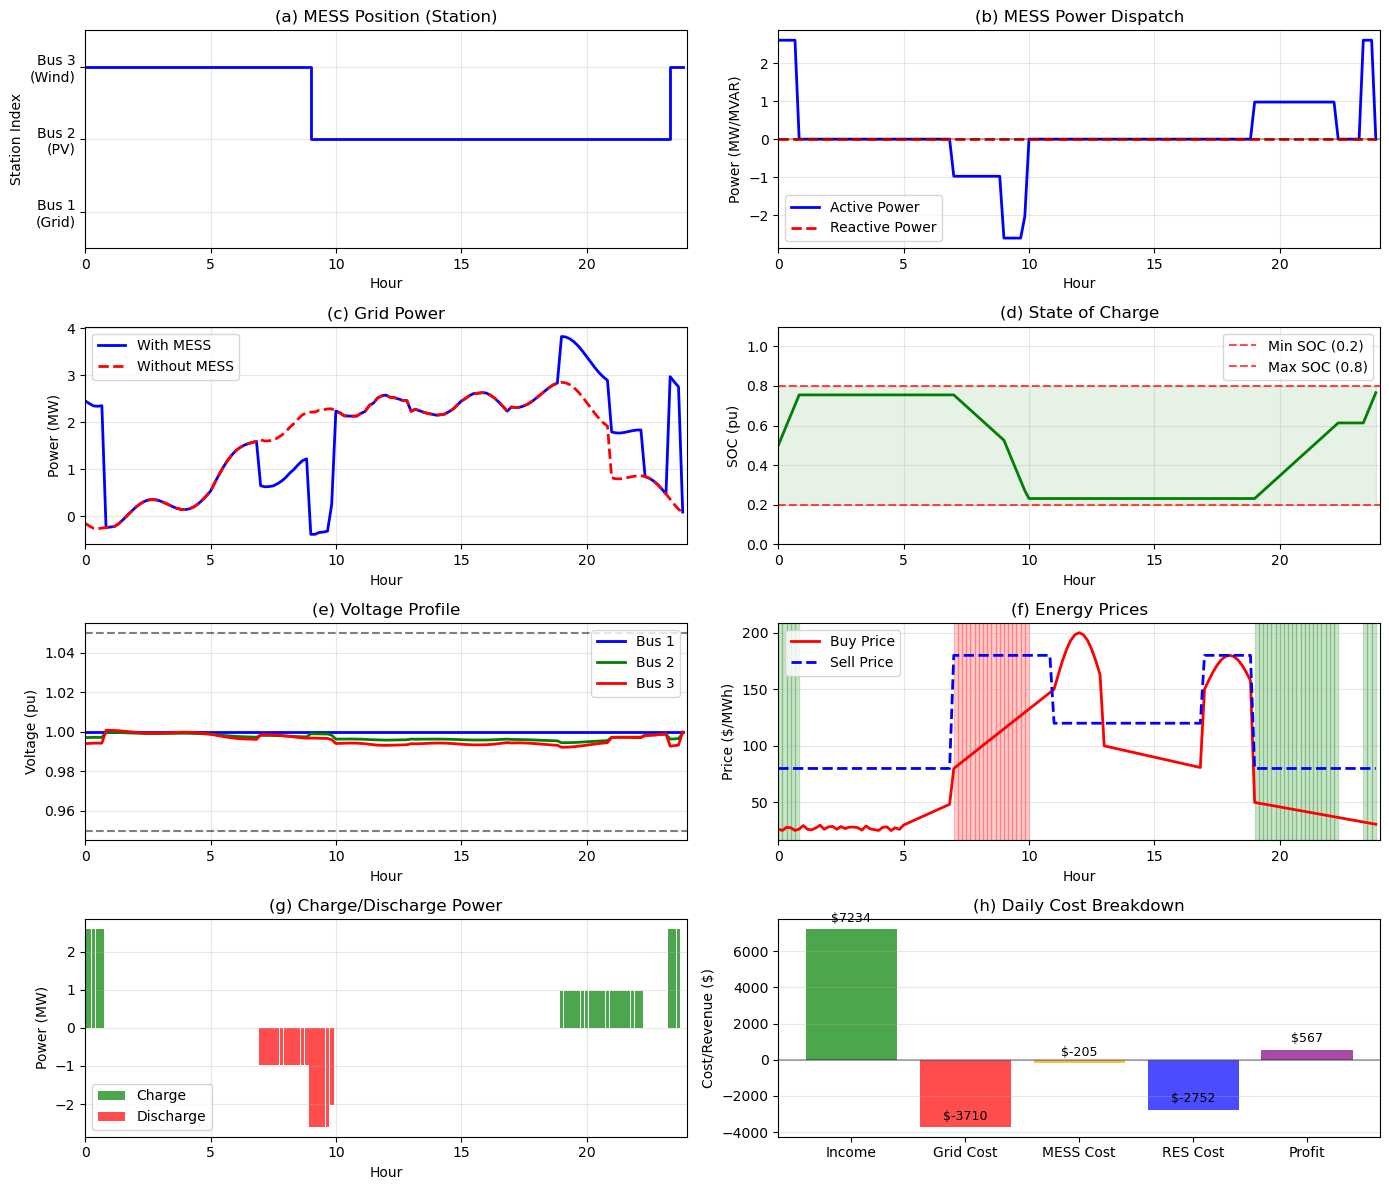


STAGE 1 RESULTS SUMMARY

MESS Schedule:
  Initial Station: 3
  Number of Trips: 3
  Transit Times (sample): [0, 54, 140]

Energy Metrics:
  Total Charged: 6.72 MWh
  Total Discharged: 4.46 MWh
  Initial SOC: 0.500
  Final SOC: 0.766

Financial Results:
  Income: $7233.60
  Grid Cost: $3709.63
  MESS Cost: $204.65
    - Truck: $103.90
    - ESS: $100.75
  RES Cost: $2752.32
  Net Profit: $567.00


In [300]:
def plot_stage1_results(params: SystemParameters,
                        profiles: Dict,
                        results: Dict):
    """
    Plot Stage 1 optimization results
    """
    fig, axes = plt.subplots(4, 2, figsize=(14, 12))
    
    hours = params.hours
    K = params.K
    
    # (a) MESS Position
    station_pos = np.zeros(K)
    for k in range(K):
        station_pos[k] = np.argmax(results['Z'][:, k]) + 1  # 1-indexed
    
    axes[0, 0].step(hours, station_pos, 'b-', linewidth=2, where='post')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Station Index')
    axes[0, 0].set_title('(a) MESS Position (Station)')
    axes[0, 0].set_yticks([1, 2, 3])
    axes[0, 0].set_yticklabels(['Bus 1\n(Grid)', 'Bus 2\n(PV)', 'Bus 3\n(Wind)'])
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 24])
    axes[0, 0].set_ylim([0.5, 3.5])
    
    # (b) MESS Active and Reactive Power
    axes[0, 1].plot(hours, results['P_mess'], 'b-', linewidth=2, label='Active Power')
    axes[0, 1].plot(hours, results['Q_mess'], 'r--', linewidth=2, label='Reactive Power')
    axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Power (MW/MVAR)')
    axes[0, 1].set_title('(b) MESS Power Dispatch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, 24])
    
    # (c) Grid Power
    # Calculate grid power without MESS for comparison
    P_grid_no_mess = np.zeros(K)
    for k in range(K):
        pf = calculate_power_flow_no_mess(params, profiles, k)
        P_grid_no_mess[k] = pf['P_grid']
    
    axes[1, 0].plot(hours, results['P_grid'], 'b-', linewidth=2, label='With MESS')
    axes[1, 0].plot(hours, P_grid_no_mess, 'r--', linewidth=2, label='Without MESS')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Power (MW)')
    axes[1, 0].set_title('(c) Grid Power')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0, 24])
    
    # (d) SOC
    axes[1, 1].plot(params.hours, results['SOC'][:-1], 'g-', linewidth=2)
    axes[1, 1].axhline(y=params.SOC_min, color='r', linestyle='--', alpha=0.7, label=f'Min SOC ({params.SOC_min})')
    axes[1, 1].axhline(y=params.SOC_max, color='r', linestyle='--', alpha=0.7, label=f'Max SOC ({params.SOC_max})')
    axes[1, 1].fill_between(hours, params.SOC_min, params.SOC_max, alpha=0.1, color='green')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel('SOC (pu)')
    axes[1, 1].set_title('(d) State of Charge')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim([0, 24])
    axes[1, 1].set_ylim([0, 1.1])
    
    # (e) Voltage Profile
    axes[2, 0].plot(hours, results['V'][0, :], 'b-', linewidth=2, label='Bus 1')
    axes[2, 0].plot(hours, results['V'][1, :], 'g-', linewidth=2, label='Bus 2')
    axes[2, 0].plot(hours, results['V'][2, :], 'r-', linewidth=2, label='Bus 3')
    axes[2, 0].axhline(y=np.sqrt(params.v_min), color='k', linestyle='--', alpha=0.5)
    axes[2, 0].axhline(y=np.sqrt(params.v_max), color='k', linestyle='--', alpha=0.5)
    axes[2, 0].set_xlabel('Hour')
    axes[2, 0].set_ylabel('Voltage (pu)')
    axes[2, 0].set_title('(e) Voltage Profile')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].set_xlim([0, 24])
    
    # (f) Energy Prices with MESS actions
    ax_price = axes[2, 1]
    ax_price.plot(hours, profiles['buy_price'], 'r-', linewidth=2, label='Buy Price')
    ax_price.plot(hours, profiles['sell_price'], 'b--', linewidth=2, label='Sell Price')
    ax_price.set_xlabel('Hour')
    ax_price.set_ylabel('Price ($/MWh)')
    ax_price.set_title('(f) Energy Prices')
    ax_price.legend(loc='upper left')
    ax_price.grid(True, alpha=0.3)
    ax_price.set_xlim([0, 24])
    
    # Highlight charging/discharging periods
    for k in range(K):
        if results['P_mess'][k] > 0.5:  # Charging
            ax_price.axvspan(hours[k], hours[k] + params.Ts_hour, alpha=0.2, color='green')
        elif results['P_mess'][k] < -0.5:  # Discharging
            ax_price.axvspan(hours[k], hours[k] + params.Ts_hour, alpha=0.2, color='red')
    
    # (g) Charge and Discharge Power
    axes[3, 0].bar(hours, results['P_ch'], width=0.15, color='green', alpha=0.7, label='Charge')
    axes[3, 0].bar(hours, results['P_dh'], width=0.15, color='red', alpha=0.7, label='Discharge')
    axes[3, 0].set_xlabel('Hour')
    axes[3, 0].set_ylabel('Power (MW)')
    axes[3, 0].set_title('(g) Charge/Discharge Power')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    axes[3, 0].set_xlim([0, 24])
    
    # (h) Cost Breakdown
    profit = results['profit_breakdown']
    categories = ['Income', 'Grid Cost', 'MESS Cost', 'RES Cost', 'Profit']
    values = [profit['income'], -profit['C_grid'], -profit['C_mess'], -profit['C_res'], profit['profit']]
    colors = ['green', 'red', 'orange', 'blue', 'purple']
    
    bars = axes[3, 1].bar(categories, values, color=colors, alpha=0.7)
    axes[3, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[3, 1].set_ylabel('Cost/Revenue ($)')
    axes[3, 1].set_title('(h) Daily Cost Breakdown')
    axes[3, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[3, 1].annotate(f'${val:.0f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('stage1_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("STAGE 1 RESULTS SUMMARY")
    print("="*60)
    print(f"\nMESS Schedule:")
    print(f"  Initial Station: {np.argmax(results['Z'][:, 0]) + 1}")
    print(f"  Number of Trips: {results['n_trips']}")
    print(f"  Transit Times (sample): {results['transit_times']}")
    
    print(f"\nEnergy Metrics:")
    print(f"  Total Charged: {np.sum(results['P_ch']) * params.Ts_hour:.2f} MWh")
    print(f"  Total Discharged: {-np.sum(results['P_dh']) * params.Ts_hour:.2f} MWh")
    print(f"  Initial SOC: {results['SOC'][0]:.3f}")
    print(f"  Final SOC: {results['SOC'][-1]:.3f}")
    
    print(f"\nFinancial Results:")
    print(f"  Income: ${profit['income']:.2f}")
    print(f"  Grid Cost: ${profit['C_grid']:.2f}")
    print(f"  MESS Cost: ${profit['C_mess']:.2f}")
    print(f"    - Truck: ${profit['C_truck']:.2f}")
    print(f"    - ESS: ${profit['C_ess']:.2f}")
    print(f"  RES Cost: ${profit['C_res']:.2f}")
    print(f"  Net Profit: ${profit['profit']:.2f}")


# Plot Stage 1 results
plot_stage1_results(params, profiles, stage1_results)

In [301]:
def calculate_real_profit_with_delay(params: SystemParameters,
                                      profiles: Dict,
                                      stage1_results: Dict,
                                      tau_matrix: np.ndarray,
                                      transit_times: List[int]) -> Tuple[float, np.ndarray, bool]:
    """
    Calculate real profit considering transit delay (Eq. 44) 
    R_pro = pro + sum_{λ∈N_τ} sum_s (Ts * BP_λ * p_sλ) + sum_{λ∈N_τ} sum_s (P_ch_sλ * Ts * C_kwh)
    """
    K = params.K
    Z = stage1_results['Z']
    P_ch = stage1_results['P_ch'].copy()
    P_dh = stage1_results['P_dh'].copy()
    P_mess = stage1_results['P_mess'].copy()
    
    # Build transit set N_tau (Eq. 43)
    N_tau = []
    
    for i, t_start in enumerate(transit_times):
        if t_start >= K - 1:
            continue
            
        # Find which stations are involved
        station_from = np.argmax(Z[:, t_start])
        
        # Find next station (after transit)
        next_k = min(t_start + 1, K - 1)
        while next_k < K and np.argmax(Z[:, next_k]) == station_from:
            next_k += 1
        
        if next_k < K:
            station_to = np.argmax(Z[:, next_k])
        else:
            continue
        
        if station_from != station_to:
            tau = tau_matrix[station_from, station_to, t_start]
            t_end = min(t_start + tau, K - 1)
            N_tau.append((t_start, t_end))
    
    # Calculate real SOC (Eq. 45)
    RSOC = np.zeros(K + 1)
    RSOC[0] = params.SOC_init
    
    in_transit = np.zeros(K, dtype=bool)
    for start, end in N_tau:
        for k in range(start, min(end + 1, K)):
            in_transit[k] = True
    
    for k in range(K):
        if in_transit[k]:
            # During transit: SOC stays constant
            RSOC[k + 1] = RSOC[k]
        else:
            # Normal operation
            RSOC[k + 1] = calculate_soc_dynamics(params, RSOC[k], P_ch[k], P_dh[k])
    # Check SOC feasibility
    feasible = True
    for k in range(K + 1):
        if RSOC[k] < params.SOC_min - 0.01 or RSOC[k] > params.SOC_max + 0.01:
            feasible = False
            break
    # Calculate real profit (Eq. 44)
    # Start with Stage 1 profit
    base_profit = stage1_results['profit_breakdown']['profit']
    # Adjustment for transit periods
    transit_adjustment = 0
    for start, end in N_tau:
        for k in range(start, min(end + 1, K)):
            # During transit, MESS power is not available
            # If MESS was supposed to discharge, grid must supply
            # If MESS was supposed to charge, energy goes to grid (or curtailed)
            
            # Grid compensation
            transit_adjustment += params.Ts_hour * profiles['buy_price'][k] * P_mess[k]
            
            # Avoided ESS cost (if was charging)
            if P_ch[k] > 0:
                transit_adjustment += P_ch[k] * params.Ts_hour * params.C_kwh
    R_pro = base_profit + transit_adjustment
    
    return R_pro, RSOC, feasible


def stage2_pso_optimizer(params: SystemParameters,
                         profiles: Dict,
                         stage1_results: Dict,
                         tau_matrix: np.ndarray) -> Dict:
    """
    Stage 2: PSO Profit Maximizer with Transit Delay
    """
    print("\n" + "="*60)
    print("STAGE 2: PSO Profit Maximizer (With Transit Delay)")
    print("="*60)
    
    # Get initial transit times from Stage 1
    initial_transit_times = stage1_results['transit_times'].copy()
    n_transits = len(initial_transit_times)
    
    if n_transits == 0:
        print("\nNo transits in Stage 1 - Stage 2 not needed")
        R_pro, RSOC, feasible = calculate_real_profit_with_delay(
            params, profiles, stage1_results, tau_matrix, []
        )
        return {
            'transit_times': [],
            'R_pro': R_pro,
            'RSOC': RSOC,
            'feasible': feasible,
            'iterations': 0,
            'convergence_history': [R_pro]
        }
    
    print(f"\nInitial transit times from Stage 1: {initial_transit_times}")
    print(f"Number of transits to optimize: {n_transits}")
    
    # PSO parameters
    n_particles = params.n_particles
    max_iter = min(params.alpha_max, 500)  # Reduce for speed
    M = params.M  # Shift limit in samples
    
    # Initialize particles
    particles = np.zeros((n_particles, n_transits))
    velocities = np.zeros((n_particles, n_transits))
    
    for n in range(n_particles):
        for i in range(n_transits):
            # Random initialization within bounds
            particles[n, i] = initial_transit_times[i] + np.random.randint(-M, M + 1)
            particles[n, i] = max(0, min(params.K - 1, particles[n, i]))
    
    # Evaluate initial fitness
    fitness = np.zeros(n_particles)
    for n in range(n_particles):
        transit_times = [int(particles[n, i]) for i in range(n_transits)]
        R_pro, RSOC, feasible = calculate_real_profit_with_delay(
            params, profiles, stage1_results, tau_matrix, transit_times
        )
        if feasible:
            fitness[n] = R_pro
        else:
            fitness[n] = -1e10  # Penalty for infeasible
    
    # Initialize best positions
    p_best = particles.copy()
    p_best_fitness = fitness.copy()
    
    g_best_idx = np.argmax(fitness)
    g_best = particles[g_best_idx].copy()
    g_best_fitness = fitness[g_best_idx]
    
    # Convergence history
    convergence_history = [g_best_fitness]
    
    print(f"\nInitial best fitness: ${g_best_fitness:.2f}")
    print(f"Initial best transit times: {[int(t) for t in g_best]}")
    
    # PSO iteration
    print("\nRunning PSO iterations...")
    
    convergence_count = 0
    prev_best = g_best_fitness
    
    for alpha in range(max_iter):
        # Update inertia (Eq. 52)
        omega = params.omega_max - (params.omega_max - params.omega_min) * alpha / max_iter
        
        for n in range(n_particles):
            # Random coefficients
            r1 = np.random.rand(n_transits)
            r2 = np.random.rand(n_transits)
            
            # Update velocity (Eq. 53)
            velocities[n] = (omega * velocities[n] +
                           params.C1 * r1 * (p_best[n] - particles[n]) +
                           params.C2 * r2 * (g_best - particles[n]))
            
            # Update position (Eq. 54)
            particles[n] = particles[n] + velocities[n]
            
            # Apply bounds
            for i in range(n_transits):
                lb = max(0, initial_transit_times[i] - M)
                ub = min(params.K - 1, initial_transit_times[i] + M)
                particles[n, i] = max(lb, min(ub, particles[n, i]))
            
            # Evaluate fitness
            transit_times = [int(particles[n, i]) for i in range(n_transits)]
            R_pro, RSOC, feasible = calculate_real_profit_with_delay(
                params, profiles, stage1_results, tau_matrix, transit_times
            )
            
            if feasible:
                fitness[n] = R_pro
            else:
                fitness[n] = -1e10
            
            # Update personal best
            if fitness[n] > p_best_fitness[n]:
                p_best[n] = particles[n].copy()
                p_best_fitness[n] = fitness[n]
            
            # Update global best
            if fitness[n] > g_best_fitness:
                g_best = particles[n].copy()
                g_best_fitness = fitness[n]
        
        convergence_history.append(g_best_fitness)
        
        # Check convergence
        if abs(g_best_fitness - prev_best) < 0.01:
            convergence_count += 1
        else:
            convergence_count = 0
        
        prev_best = g_best_fitness
        
        if convergence_count >= 50:
            print(f"  Converged at iteration {alpha}")
            break
        
        if alpha % 50 == 0:
            print(f"  Iteration {alpha}: Best profit = ${g_best_fitness:.2f}")
    
    # Final results
    optimal_transit_times = [int(g_best[i]) for i in range(n_transits)]
    R_pro_final, RSOC_final, feasible_final = calculate_real_profit_with_delay(
        params, profiles, stage1_results, tau_matrix, optimal_transit_times
    )
    
    results = {
        'transit_times': optimal_transit_times,
        'R_pro': R_pro_final,
        'RSOC': RSOC_final,
        'feasible': feasible_final,
        'iterations': alpha + 1,
        'convergence_history': convergence_history,
        'initial_transit_times': initial_transit_times
    }
    
    print(f"\nStage 2 Results:")
    print(f"  Initial transit times: {initial_transit_times}")
    print(f"  Optimized transit times: {optimal_transit_times}")
    print(f"  Stage 1 profit: ${stage1_results['profit_breakdown']['profit']:.2f}")
    print(f"  Real profit (with delay): ${R_pro_final:.2f}")
    print(f"  Profit change: ${R_pro_final - stage1_results['profit_breakdown']['profit']:.2f}")
    print(f"  Feasible: {feasible_final}")
    print(f"  Iterations: {alpha + 1}")
    
    return results


# Run Stage 2
stage2_results = stage2_pso_optimizer(params, profiles, stage1_results, tau_matrix)


STAGE 2: PSO Profit Maximizer (With Transit Delay)

Initial transit times from Stage 1: [0, 54, 140]
Number of transits to optimize: 3

Initial best fitness: $491.21
Initial best transit times: [0, 52, 138]

Running PSO iterations...
  Iteration 0: Best profit = $491.21
  Iteration 50: Best profit = $528.47
  Converged at iteration 53

Stage 2 Results:
  Initial transit times: [0, 54, 140]
  Optimized transit times: [2, 51, 139]
  Stage 1 profit: $567.00
  Real profit (with delay): $528.47
  Profit change: $-38.53
  Feasible: True
  Iterations: 54


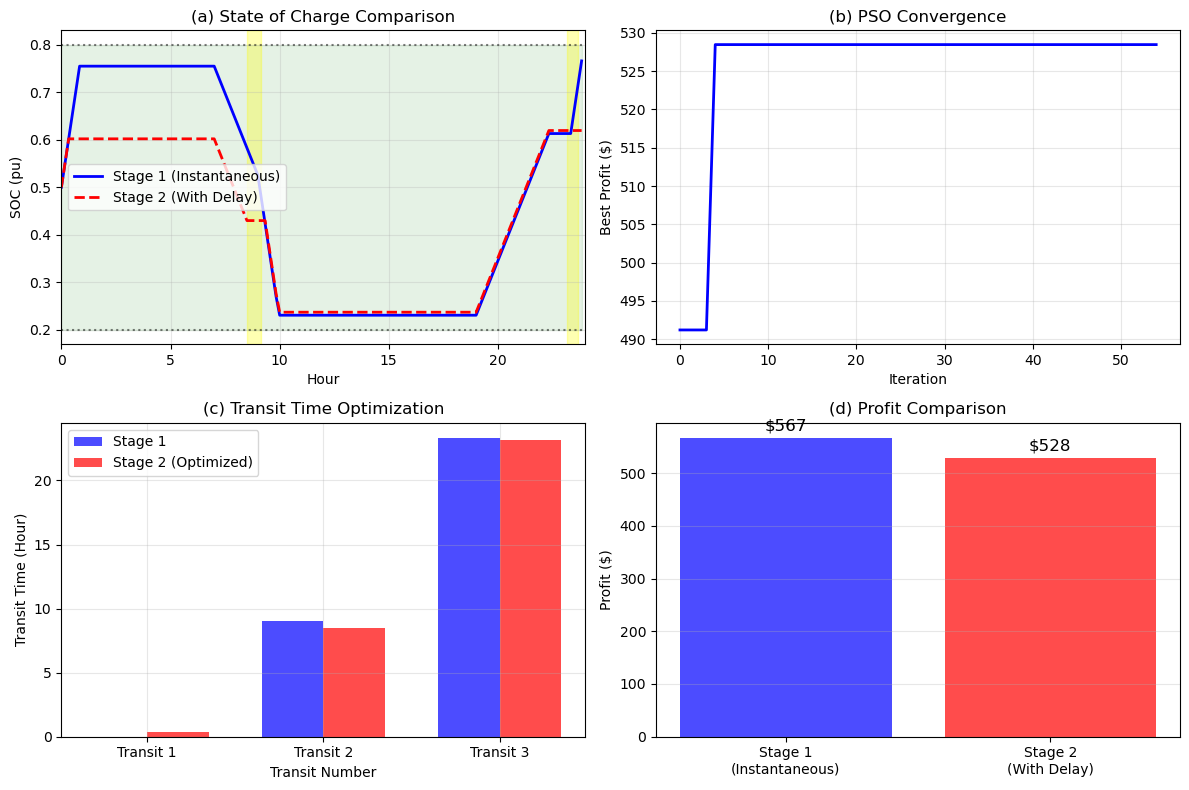


STAGE 1 vs STAGE 2 COMPARISON

Transit Times:
  Stage 1 (samples): [0, 54, 140]
  Stage 2 (samples): [2, 51, 139]

  Stage 1 (hours): ['0.0', '9.0', '23.3']
  Stage 2 (hours): ['0.3', '8.5', '23.2']

Profit:
  Stage 1 (Instantaneous): $567.00
  Stage 2 (With Delay): $528.47
  Difference: $-38.53
  Improvement: -6.80%


In [302]:
def plot_stage2_results(params: SystemParameters,
                        profiles: Dict,
                        stage1_results: Dict,
                        stage2_results: Dict):
    """
    Plot Stage 2 optimization results and comparison
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    hours = params.hours
    K = params.K
    
    # (a) SOC Comparison
    axes[0, 0].plot(hours, stage1_results['SOC'][:-1], 'b-', linewidth=2, label='Stage 1 (Instantaneous)')
    axes[0, 0].plot(hours, stage2_results['RSOC'][:-1], 'r--', linewidth=2, label='Stage 2 (With Delay)')
    axes[0, 0].axhline(y=params.SOC_min, color='k', linestyle=':', alpha=0.5)
    axes[0, 0].axhline(y=params.SOC_max, color='k', linestyle=':', alpha=0.5)
    axes[0, 0].fill_between(hours, params.SOC_min, params.SOC_max, alpha=0.1, color='green')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('SOC (pu)')
    axes[0, 0].set_title('(a) State of Charge Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 24])
    
    # Mark transit periods
    if len(stage2_results['transit_times']) > 0:
        Z = stage1_results['Z']
        for t_start in stage2_results['transit_times']:
            if t_start < K - 1:
                station_from = np.argmax(Z[:, t_start])
                station_to = np.argmax(Z[:, min(t_start + 5, K-1)])
                if station_from != station_to:
                    tau = tau_matrix[station_from, station_to, t_start]
                    t_end = min(t_start + tau, K - 1)
                    axes[0, 0].axvspan(hours[t_start], hours[min(t_end, K-1)], 
                                       alpha=0.3, color='yellow', label='Transit')
    
    # (b) Convergence History
    axes[0, 1].plot(stage2_results['convergence_history'], 'b-', linewidth=2)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Best Profit ($)')
    axes[0, 1].set_title('(b) PSO Convergence')
    axes[0, 1].grid(True, alpha=0.3)
    
    # (c) Transit Time Comparison
    if len(stage2_results['transit_times']) > 0:
        x = np.arange(len(stage2_results['transit_times']))
        width = 0.35
        
        initial_hours = [hours[t] for t in stage2_results['initial_transit_times']]
        optimized_hours = [hours[t] for t in stage2_results['transit_times']]
        
        axes[1, 0].bar(x - width/2, initial_hours, width, label='Stage 1', color='blue', alpha=0.7)
        axes[1, 0].bar(x + width/2, optimized_hours, width, label='Stage 2 (Optimized)', color='red', alpha=0.7)
        axes[1, 0].set_xlabel('Transit Number')
        axes[1, 0].set_ylabel('Transit Time (Hour)')
        axes[1, 0].set_title('(c) Transit Time Optimization')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels([f'Transit {i+1}' for i in x])
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No Transits', ha='center', va='center', fontsize=14)
        axes[1, 0].set_title('(c) Transit Time Optimization')
    
    # (d) Profit Comparison
    categories = ['Stage 1\n(Instantaneous)', 'Stage 2\n(With Delay)']
    profits = [stage1_results['profit_breakdown']['profit'], stage2_results['R_pro']]
    colors = ['blue', 'red']
    
    bars = axes[1, 1].bar(categories, profits, color=colors, alpha=0.7)
    axes[1, 1].set_ylabel('Profit ($)')
    axes[1, 1].set_title('(d) Profit Comparison')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, profits):
        height = bar.get_height()
        axes[1, 1].annotate(f'${val:.0f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('stage2_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print comparison
    print("\n" + "="*60)
    print("STAGE 1 vs STAGE 2 COMPARISON")
    print("="*60)
    
    print(f"\nTransit Times:")
    print(f"  Stage 1 (samples): {stage2_results['initial_transit_times']}")
    print(f"  Stage 2 (samples): {stage2_results['transit_times']}")
    
    if len(stage2_results['transit_times']) > 0:
        print(f"\n  Stage 1 (hours): {[f'{hours[t]:.1f}' for t in stage2_results['initial_transit_times']]}")
        print(f"  Stage 2 (hours): {[f'{hours[t]:.1f}' for t in stage2_results['transit_times']]}")
    
    print(f"\nProfit:")
    print(f"  Stage 1 (Instantaneous): ${stage1_results['profit_breakdown']['profit']:.2f}")
    print(f"  Stage 2 (With Delay): ${stage2_results['R_pro']:.2f}")
    print(f"  Difference: ${stage2_results['R_pro'] - stage1_results['profit_breakdown']['profit']:.2f}")
    
    improvement = ((stage2_results['R_pro'] - stage1_results['profit_breakdown']['profit']) / 
                   abs(stage1_results['profit_breakdown']['profit'])) * 100
    print(f"  Improvement: {improvement:.2f}%")


# Plot Stage 2 results
plot_stage2_results(params, profiles, stage1_results, stage2_results)

In [303]:
def compare_with_without_mess(params: SystemParameters,
                               profiles: Dict,
                               stage1_results: Dict,
                               stage2_results: Dict):
    """
    Compare system performance with and without MESS - CORRECTED VERSION
    """
    print("\n" + "="*70)
    print("FINAL RESULTS: SYSTEM PERFORMANCE COMPARISON")
    print("="*70)
    
    K = params.K
    
    # Calculate performance without MESS
    P_grid_no_mess = np.zeros(K)
    V_no_mess = np.zeros((3, K))
    P_loss_no_mess = np.zeros(K)
    
    for k in range(K):
        pf = calculate_power_flow_no_mess(params, profiles, k)
        P_grid_no_mess[k] = pf['P_grid']
        V_no_mess[:, k] = pf['V']
        P_loss_no_mess[k] = pf['P_loss']
    
    # Calculate profit without MESS
    P_ch_zero = np.zeros(K)
    P_dh_zero = np.zeros(K)
    profit_no_mess = calculate_profit(params, profiles, P_grid_no_mess, P_ch_zero, P_dh_zero, 0)
    
    # Calculate performance with MESS
    P_loss_with_mess = np.zeros(K)
    for k in range(K):
        station = np.argmax(stage1_results['Z'][:, k])
        pf = calculate_power_flow(params, profiles, stage1_results['P_mess'][k], 
                                  stage1_results['Q_mess'][k], station, k)
        P_loss_with_mess[k] = pf['P_loss']
    
    # Voltage statistics
    V_min_no_mess = np.min(V_no_mess[1:, :])
    V_max_no_mess = np.max(V_no_mess[1:, :])
    V_min_with_mess = np.min(stage1_results['V'][1:, :])
    V_max_with_mess = np.max(stage1_results['V'][1:, :])
    
    # Power loss statistics (in kWh)
    total_loss_no_mess = np.sum(P_loss_no_mess) * params.Ts_hour * 1000
    total_loss_with_mess = np.sum(P_loss_with_mess) * params.Ts_hour * 1000
    
    # Grid energy statistics
    grid_import_no_mess = np.sum(P_grid_no_mess[P_grid_no_mess > 0]) * params.Ts_hour
    grid_import_with_mess = np.sum(stage1_results['P_grid'][stage1_results['P_grid'] > 0]) * params.Ts_hour
    
    # Print comparison table
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Without MESS':>15} {'With MESS':>15}")
    print("-"*70)
    
    print(f"{'Voltage Level (pu):':<35}")
    print(f"{'  - Minimum':<35} {V_min_no_mess:>15.4f} {V_min_with_mess:>15.4f}")
    print(f"{'  - Maximum':<35} {V_max_no_mess:>15.4f} {V_max_with_mess:>15.4f}")
    
    print(f"{'Grid Energy Import (MWh/day):':<35} {grid_import_no_mess:>15.2f} {grid_import_with_mess:>15.2f}")
    
    if total_loss_no_mess > 0:
        loss_reduction = (total_loss_no_mess - total_loss_with_mess) / total_loss_no_mess * 100
    else:
        loss_reduction = 0
    print(f"{'Power Losses (kWh/day):':<35} {total_loss_no_mess:>15.2f} {total_loss_with_mess:>15.2f}")
    print(f"{'  - Reduction':<35} {'-':>15} {f'{loss_reduction:.1f}%':>15}")
    
    print(f"\n{'Cost Breakdown ($):':<35}")
    print(f"{'  - Income':<35} {profit_no_mess['income']:>15.2f} {stage1_results['profit_breakdown']['income']:>15.2f}")
    print(f"{'  - Grid Cost':<35} {profit_no_mess['C_grid']:>15.2f} {stage1_results['profit_breakdown']['C_grid']:>15.2f}")
    print(f"{'  - MESS Cost':<35} {profit_no_mess['C_mess']:>15.2f} {stage1_results['profit_breakdown']['C_mess']:>15.2f}")
    print(f"{'  - RES Cost':<35} {profit_no_mess['C_res']:>15.2f} {stage1_results['profit_breakdown']['C_res']:>15.2f}")
    
    print(f"\n{'Daily Profit ($):':<35} {profit_no_mess['profit']:>15.2f} {stage2_results['R_pro']:>15.2f}")
    
    profit_increase = stage2_results['R_pro'] - profit_no_mess['profit']
    if profit_no_mess['profit'] != 0:
        profit_increase_pct = profit_increase / abs(profit_no_mess['profit']) * 100
    else:
        profit_increase_pct = 0
    
    print(f"{'  - Increase':<35} {'-':>15} {f'${profit_increase:.2f}':>15}")
    print(f"{'  - Percentage':<35} {'-':>15} {f'{profit_increase_pct:.1f}%':>15}")
    
    print("-"*70)
    
    # Voltage constraint check
    print("\nVoltage Constraint Check:")
    v_min_limit = np.sqrt(params.v_min)
    v_max_limit = np.sqrt(params.v_max)
    
    no_mess_violation = V_min_no_mess < v_min_limit or V_max_no_mess > v_max_limit
    with_mess_violation = V_min_with_mess < v_min_limit or V_max_with_mess > v_max_limit
    
    print(f"  Limits: [{v_min_limit:.2f}, {v_max_limit:.2f}] pu")
    print(f"  Without MESS: {'VIOLATED' if no_mess_violation else 'OK'}")
    print(f"  With MESS: {'VIOLATED' if with_mess_violation else 'OK'}")
    
    # Arbitrage benefit analysis
    print("\nArbitrage Analysis:")
    total_charged = np.sum(stage1_results['P_ch']) * params.Ts_hour
    total_discharged = -np.sum(stage1_results['P_dh']) * params.Ts_hour
    
    # Average price during charging vs discharging
    if total_charged > 0:
        avg_charge_price = np.sum(stage1_results['P_ch'] * profiles['buy_price']) / np.sum(stage1_results['P_ch'])
    else:
        avg_charge_price = 0
    
    if total_discharged > 0:
        discharge_mask = stage1_results['P_dh'] < 0
        avg_discharge_price = np.sum(-stage1_results['P_dh'][discharge_mask] * profiles['buy_price'][discharge_mask]) / np.sum(-stage1_results['P_dh'][discharge_mask])
    else:
        avg_discharge_price = 0
    
    print(f"  Energy Charged: {total_charged:.2f} MWh at avg ${avg_charge_price:.1f}/MWh")
    print(f"  Energy Discharged: {total_discharged:.2f} MWh at avg ${avg_discharge_price:.1f}/MWh")
    print(f"  Price Spread: ${avg_discharge_price - avg_charge_price:.1f}/MWh")
    
    # Return comparison data
    return {
        'V_min_no_mess': V_min_no_mess,
        'V_max_no_mess': V_max_no_mess,
        'V_min_with_mess': V_min_with_mess,
        'V_max_with_mess': V_max_with_mess,
        'loss_no_mess': total_loss_no_mess,
        'loss_with_mess': total_loss_with_mess,
        'profit_no_mess': profit_no_mess['profit'],
        'profit_with_mess': stage2_results['R_pro'],
        'P_grid_no_mess': P_grid_no_mess,
        'V_no_mess': V_no_mess,
        'grid_import_no_mess': grid_import_no_mess,
        'grid_import_with_mess': grid_import_with_mess
    }


# Run comparison
comparison = compare_with_without_mess(params, profiles, stage1_results, stage2_results)


FINAL RESULTS: SYSTEM PERFORMANCE COMPARISON

----------------------------------------------------------------------
Metric                                 Without MESS       With MESS
----------------------------------------------------------------------
Voltage Level (pu):                
  - Minimum                                  0.9931          0.9921
  - Maximum                                  1.0007          1.0007
Grid Energy Import (MWh/day):                 37.53           39.90
Power Losses (kWh/day):                      112.19          131.20
  - Reduction                                     -          -17.0%

Cost Breakdown ($):                
  - Income                                  7233.60         7233.60
  - Grid Cost                               3946.34         3709.63
  - MESS Cost                                  0.00          204.65
  - RES Cost                                2752.32         2752.32

Daily Profit ($):                            534.94      

In [304]:
# =========================================================================
# TEST: Verify Paper's Power Flow Equations
# =========================================================================
print("="*70)
print("TESTING PAPER'S POWER FLOW EQUATIONS")
print("="*70)

# Test at peak load hour
k_test = 108  # 6 PM
print(f"\nTest at k={k_test} ({params.hours[k_test]:.1f}h):")
print(f"  Load Bus 2: {profiles['P_load'][1, k_test]:.3f} MW")
print(f"  Load Bus 3: {profiles['P_load'][2, k_test]:.3f} MW")
print(f"  PV (Bus 2): {profiles['P_PV'][k_test]:.3f} MW")
print(f"  Wind (Bus 3): {profiles['P_WT'][k_test]:.3f} MW")

# Case 1: No MESS
pf1 = calculate_power_flow_paper(params, profiles, 0.0, 0.0, 0, k_test)
print(f"\n{'='*50}")
print("CASE 1: WITHOUT MESS")
print(f"{'='*50}")
print(f"  Branch Powers (Eq. 8-9):")
print(f"    p_1 (Branch 1): {pf1['p_branch'][0]:.4f} MW")
print(f"    p_2 (Branch 2): {pf1['p_branch'][1]:.4f} MW")
print(f"    q_1 (Branch 1): {pf1['q_branch'][0]:.4f} MVAR")
print(f"    q_2 (Branch 2): {pf1['q_branch'][1]:.4f} MVAR")
print(f"  Current Squared (Eq. 11):")
print(f"    ℓ_1: {pf1['ell'][0]:.6f} pu")
print(f"    ℓ_2: {pf1['ell'][1]:.6f} pu")
print(f"  Voltage Squared (Eq. 10):")
print(f"    v_1: {pf1['v_squared'][0]:.6f} pu (V={pf1['V'][0]:.4f})")
print(f"    v_2: {pf1['v_squared'][1]:.6f} pu (V={pf1['V'][1]:.4f})")
print(f"    v_3: {pf1['v_squared'][2]:.6f} pu (V={pf1['V'][2]:.4f})")
print(f"  Losses (Eq. 14):")
print(f"    Branch 1: {pf1['P_loss_branch'][0]*1000:.2f} kW")
print(f"    Branch 2: {pf1['P_loss_branch'][1]*1000:.2f} kW")
print(f"    Total: {pf1['P_loss']*1000:.2f} kW")
print(f"  Grid Power: {pf1['P_grid']:.4f} MW")
print(f"  Iterations: {pf1['iterations']}")
print(f"  SOCP OK: {pf1['socp_ok']}")
print(f"  Voltage OK: {pf1['voltage_ok']}")

# Case 2: MESS Discharging 2 MW at Bus 3
pf2 = calculate_power_flow_paper(params, profiles, -2.0, 0.0, 2, k_test)
print(f"\n{'='*50}")
print("CASE 2: MESS DISCHARGING 2 MW AT BUS 3")
print(f"{'='*50}")
print(f"  Branch Powers (Eq. 8-9):")
print(f"    p_1 (Branch 1): {pf2['p_branch'][0]:.4f} MW")
print(f"    p_2 (Branch 2): {pf2['p_branch'][1]:.4f} MW")
print(f"  Current Squared (Eq. 11):")
print(f"    ℓ_1: {pf2['ell'][0]:.6f} pu")
print(f"    ℓ_2: {pf2['ell'][1]:.6f} pu")
print(f"  Voltage (Eq. 10):")
print(f"    V_2: {pf2['V'][1]:.4f} pu")
print(f"    V_3: {pf2['V'][2]:.4f} pu")
print(f"  Losses (Eq. 14):")
print(f"    Total: {pf2['P_loss']*1000:.2f} kW")
print(f"  Grid Power: {pf2['P_grid']:.4f} MW")

# Case 3: MESS Charging 2 MW at Bus 3
pf3 = calculate_power_flow_paper(params, profiles, 2.0, 0.0, 2, k_test)
print(f"\n{'='*50}")
print("CASE 3: MESS CHARGING 2 MW AT BUS 3")
print(f"{'='*50}")
print(f"  Branch Powers (Eq. 8-9):")
print(f"    p_1 (Branch 1): {pf3['p_branch'][0]:.4f} MW")
print(f"    p_2 (Branch 2): {pf3['p_branch'][1]:.4f} MW")
print(f"  Losses (Eq. 14):")
print(f"    Total: {pf3['P_loss']*1000:.2f} kW")
print(f"  Grid Power: {pf3['P_grid']:.4f} MW")

# Summary
print(f"\n{'='*70}")
print("SUMMARY: LOSS COMPARISON")
print(f"{'='*70}")
print(f"  No MESS:              {pf1['P_loss']*1000:.2f} kW")
print(f"  Discharge at Bus 3:   {pf2['P_loss']*1000:.2f} kW (Change: {(pf2['P_loss']-pf1['P_loss'])*1000:+.2f} kW)")
print(f"  Charge at Bus 3:      {pf3['P_loss']*1000:.2f} kW (Change: {(pf3['P_loss']-pf1['P_loss'])*1000:+.2f} kW)")

print(f"\n{'='*70}")
print("EQUATION VERIFICATION")
print(f"{'='*70}")

TESTING PAPER'S POWER FLOW EQUATIONS

Test at k=108 (18.0h):
  Load Bus 2: 1.941 MW
  Load Bus 3: 1.456 MW
  PV (Bus 2): 0.000 MW
  Wind (Bus 3): 0.882 MW

CASE 1: WITHOUT MESS
  Branch Powers (Eq. 8-9):
    p_1 (Branch 1): 2.5160 MW
    p_2 (Branch 2): 0.5738 MW
    q_1 (Branch 1): 0.8748 MVAR
    q_2 (Branch 2): 0.3883 MVAR
  Current Squared (Eq. 11):
    ℓ_1: 0.070954 pu
    ℓ_2: 0.004841 pu
  Voltage Squared (Eq. 10):
    v_1: 1.000000 pu (V=1.0000)
    v_2: 0.991504 pu (V=0.9957)
    v_3: 0.987845 pu (V=0.9939)
  Losses (Eq. 14):
    Branch 1: 7.10 kW
    Branch 2: 0.73 kW
    Total: 7.82 kW
  Grid Power: 2.5160 MW
  Iterations: 2
  SOCP OK: True
  Voltage OK: True

CASE 2: MESS DISCHARGING 2 MW AT BUS 3
  Branch Powers (Eq. 8-9):
    p_1 (Branch 1): 0.5185 MW
    p_2 (Branch 2): -1.4262 MW
  Current Squared (Eq. 11):
    ℓ_1: 0.010417 pu
    ℓ_2: 0.021948 pu
  Voltage (Eq. 10):
    V_2: 0.9977 pu
    V_3: 0.9989 pu
  Losses (Eq. 14):
    Total: 4.33 kW
  Grid Power: 0.5185 MW

CA

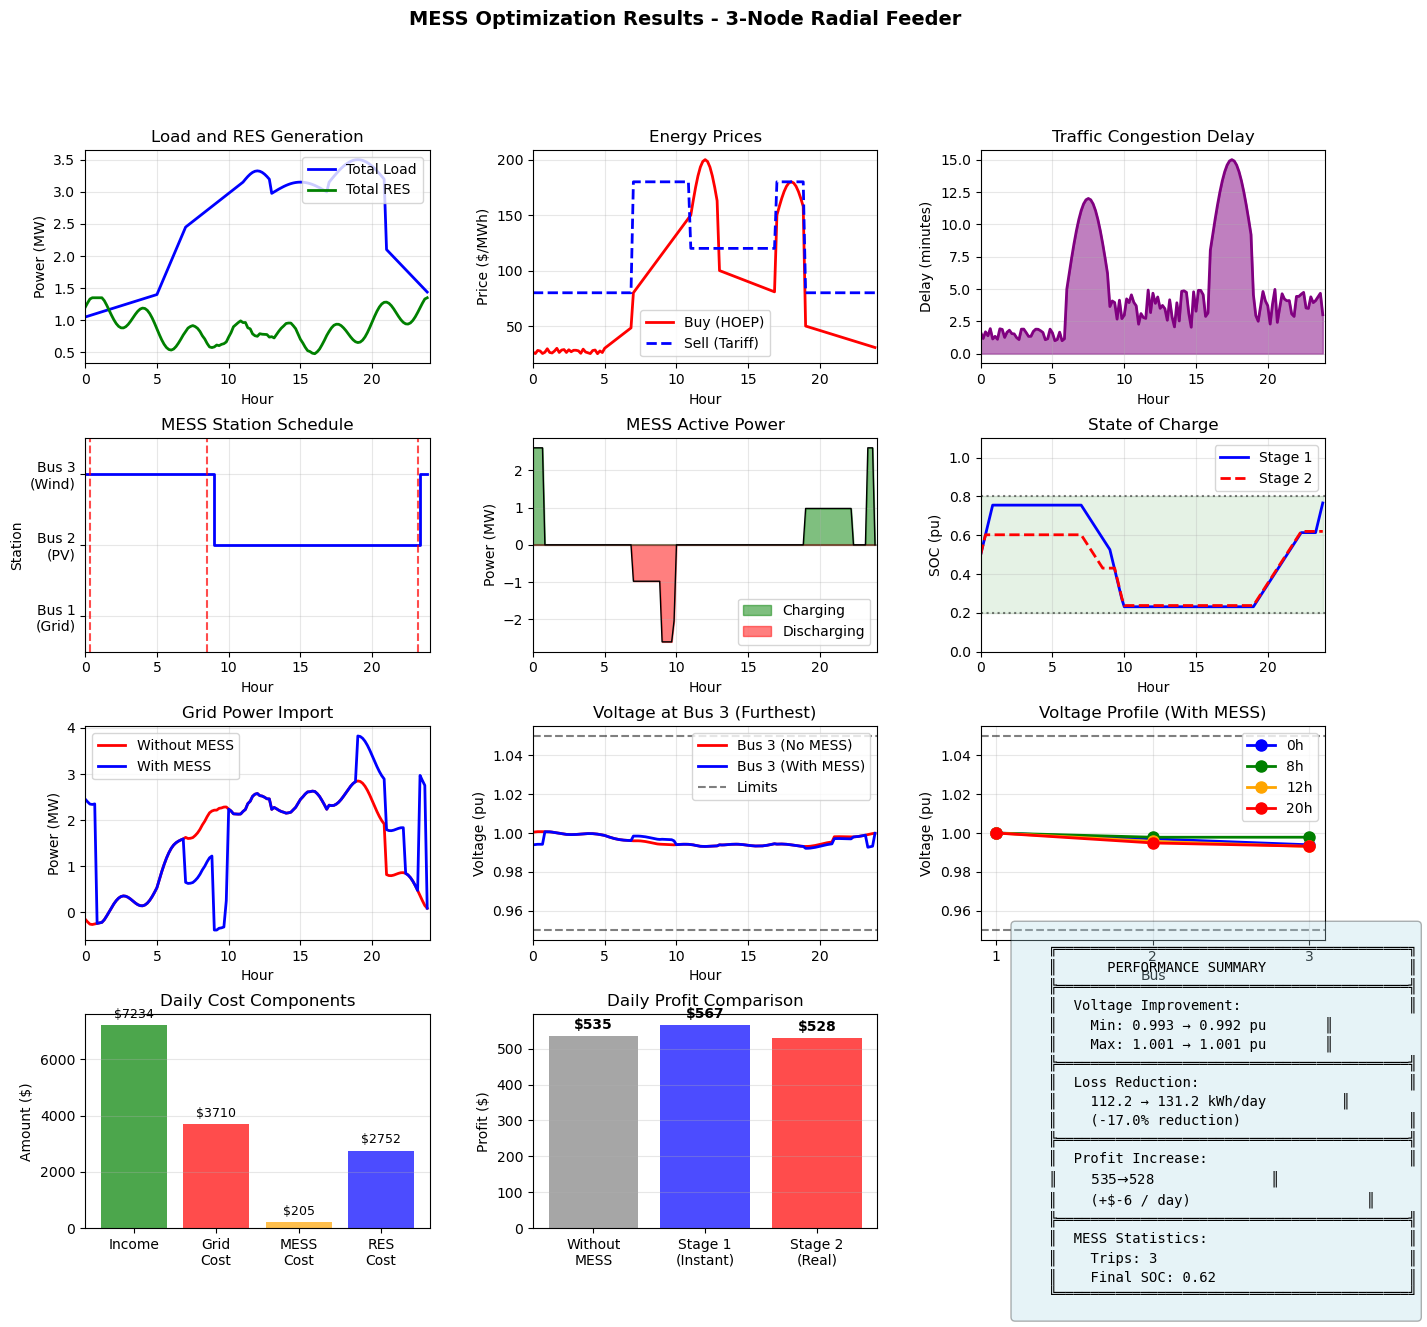

In [305]:
def plot_comprehensive_results(params: SystemParameters,
                                profiles: Dict,
                                stage1_results: Dict,
                                stage2_results: Dict,
                                comparison: Dict):
    """
    Create comprehensive visualization of all results
    """
    fig = plt.figure(figsize=(16, 14))
    
    hours = params.hours
    K = params.K
    
    # Create grid of subplots
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
    
    # =========================================================================
    # Row 1: Input Profiles
    # =========================================================================
    
    # (1,1) Load and RES
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(hours, profiles['P_load'][1, :] + profiles['P_load'][2, :], 
             'b-', linewidth=2, label='Total Load')
    ax1.plot(hours, profiles['P_PV'] + profiles['P_WT'], 
             'g-', linewidth=2, label='Total RES')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Power (MW)')
    ax1.set_title('Load and RES Generation')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 24])
    
    # (1,2) Energy Prices
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(hours, profiles['buy_price'], 'r-', linewidth=2, label='Buy (HOEP)')
    ax2.plot(hours, profiles['sell_price'], 'b--', linewidth=2, label='Sell (Tariff)')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Price ($/MWh)')
    ax2.set_title('Energy Prices')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 24])
    
    # (1,3) Traffic Delay
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.fill_between(hours, 0, profiles['traffic_delay'], alpha=0.5, color='purple')
    ax3.plot(hours, profiles['traffic_delay'], 'purple', linewidth=2)
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Delay (minutes)')
    ax3.set_title('Traffic Congestion Delay')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 24])
    
    # =========================================================================
    # Row 2: MESS Schedule and Operation
    # =========================================================================
    
    # (2,1) MESS Position
    ax4 = fig.add_subplot(gs[1, 0])
    station_pos = np.array([np.argmax(stage1_results['Z'][:, k]) + 1 for k in range(K)])
    ax4.step(hours, station_pos, 'b-', linewidth=2, where='post')
    ax4.set_xlabel('Hour')
    ax4.set_ylabel('Station')
    ax4.set_title('MESS Station Schedule')
    ax4.set_yticks([1, 2, 3])
    ax4.set_yticklabels(['Bus 1\n(Grid)', 'Bus 2\n(PV)', 'Bus 3\n(Wind)'])
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, 24])
    ax4.set_ylim([0.5, 3.5])
    
    # Mark transit times
    for t in stage2_results['transit_times']:
        if t < K:
            ax4.axvline(x=hours[t], color='red', linestyle='--', alpha=0.7)
    
    # (2,2) MESS Power
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.fill_between(hours, 0, np.maximum(stage1_results['P_mess'], 0), 
                     alpha=0.5, color='green', label='Charging')
    ax5.fill_between(hours, 0, np.minimum(stage1_results['P_mess'], 0), 
                     alpha=0.5, color='red', label='Discharging')
    ax5.plot(hours, stage1_results['P_mess'], 'k-', linewidth=1)
    ax5.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax5.set_xlabel('Hour')
    ax5.set_ylabel('Power (MW)')
    ax5.set_title('MESS Active Power')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim([0, 24])
    
    # (2,3) SOC
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(hours, stage1_results['SOC'][:-1], 'b-', linewidth=2, label='Stage 1')
    ax6.plot(hours, stage2_results['RSOC'][:-1], 'r--', linewidth=2, label='Stage 2')
    ax6.fill_between(hours, params.SOC_min, params.SOC_max, alpha=0.1, color='green')
    ax6.axhline(y=params.SOC_min, color='k', linestyle=':', alpha=0.5)
    ax6.axhline(y=params.SOC_max, color='k', linestyle=':', alpha=0.5)
    ax6.set_xlabel('Hour')
    ax6.set_ylabel('SOC (pu)')
    ax6.set_title('State of Charge')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim([0, 24])
    ax6.set_ylim([0, 1.1])
    
    # =========================================================================
    # Row 3: System Performance
    # =========================================================================
    
    # (3,1) Grid Power Comparison
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.plot(hours, comparison['P_grid_no_mess'], 'r-', linewidth=2, label='Without MESS')
    ax7.plot(hours, stage1_results['P_grid'], 'b-', linewidth=2, label='With MESS')
    ax7.set_xlabel('Hour')
    ax7.set_ylabel('Power (MW)')
    ax7.set_title('Grid Power Import')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim([0, 24])
    
    # (3,2) Voltage Comparison
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.plot(hours, comparison['V_no_mess'][2, :], 'r-', linewidth=2, label='Bus 3 (No MESS)')
    ax8.plot(hours, stage1_results['V'][2, :], 'b-', linewidth=2, label='Bus 3 (With MESS)')
    ax8.axhline(y=np.sqrt(params.v_min), color='k', linestyle='--', alpha=0.5, label='Limits')
    ax8.axhline(y=np.sqrt(params.v_max), color='k', linestyle='--', alpha=0.5)
    ax8.set_xlabel('Hour')
    ax8.set_ylabel('Voltage (pu)')
    ax8.set_title('Voltage at Bus 3 (Furthest)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    ax8.set_xlim([0, 24])
    
    # (3,3) Voltage Profile at Specific Times
    ax9 = fig.add_subplot(gs[2, 2])
    buses = [1, 2, 3]
    times_to_show = [0, 48, 72, 120]  # Midnight, 8am, Noon, 8pm
    colors = ['blue', 'green', 'orange', 'red']
    
    for i, k in enumerate(times_to_show):
        ax9.plot(buses, stage1_results['V'][:, k], 'o-', color=colors[i], 
                 linewidth=2, markersize=8, label=f'{hours[k]:.0f}h')
    
    ax9.axhline(y=np.sqrt(params.v_min), color='k', linestyle='--', alpha=0.5)
    ax9.axhline(y=np.sqrt(params.v_max), color='k', linestyle='--', alpha=0.5)
    ax9.set_xlabel('Bus')
    ax9.set_ylabel('Voltage (pu)')
    ax9.set_title('Voltage Profile (With MESS)')
    ax9.set_xticks([1, 2, 3])
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # =========================================================================
    # Row 4: Economic Results
    # =========================================================================
    
    # (4,1) Cost Breakdown
    ax10 = fig.add_subplot(gs[3, 0])
    profit = stage1_results['profit_breakdown']
    categories = ['Income', 'Grid\nCost', 'MESS\nCost', 'RES\nCost']
    values = [profit['income'], profit['C_grid'], profit['C_mess'], profit['C_res']]
    colors = ['green', 'red', 'orange', 'blue']
    
    bars = ax10.bar(categories, values, color=colors, alpha=0.7)
    ax10.set_ylabel('Amount ($)')
    ax10.set_title('Daily Cost Components')
    ax10.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax10.annotate(f'${val:.0f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)
    
    # (4,2) Profit Comparison
    ax11 = fig.add_subplot(gs[3, 1])
    scenarios = ['Without\nMESS', 'Stage 1\n(Instant)', 'Stage 2\n(Real)']
    profits = [comparison['profit_no_mess'], 
               stage1_results['profit_breakdown']['profit'],
               stage2_results['R_pro']]
    colors = ['gray', 'blue', 'red']
    
    bars = ax11.bar(scenarios, profits, color=colors, alpha=0.7)
    ax11.set_ylabel('Profit ($)')
    ax11.set_title('Daily Profit Comparison')
    ax11.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, profits):
        height = bar.get_height()
        ax11.annotate(f'${val:.0f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # (4,3) Performance Metrics Summary
    ax12 = fig.add_subplot(gs[3, 2])
    ax12.axis('off')
    
    # Create summary table
    summary_text = f"""
    ╔══════════════════════════════════════════╗
    ║      PERFORMANCE SUMMARY                 ║
    ╠══════════════════════════════════════════╣
    ║  Voltage Improvement:                    ║
    ║    Min: {comparison['V_min_no_mess']:.3f} → {comparison['V_min_with_mess']:.3f} pu       ║
    ║    Max: {comparison['V_max_no_mess']:.3f} → {comparison['V_max_with_mess']:.3f} pu       ║
    ╠══════════════════════════════════════════╣
    ║  Loss Reduction:                         ║
    ║    {comparison['loss_no_mess']:.1f} → {comparison['loss_with_mess']:.1f} kWh/day         ║
    ║    ({(comparison['loss_no_mess']-comparison['loss_with_mess'])/comparison['loss_no_mess']*100:.1f}% reduction)                    ║
    ╠══════════════════════════════════════════╣
    ║  Profit Increase:                        ║
    ║    ${comparison['profit_no_mess']:.0f} → ${stage2_results['R_pro']:.0f}              ║
    ║    (+${stage2_results['R_pro']-comparison['profit_no_mess']:.0f} / day)                     ║
    ╠══════════════════════════════════════════╣
    ║  MESS Statistics:                        ║
    ║    Trips: {stage1_results['n_trips']}                              ║
    ║    Final SOC: {stage2_results['RSOC'][-1]:.2f}                       ║
    ╚══════════════════════════════════════════╝
    """
    
    ax12.text(0.1, 0.5, summary_text, transform=ax12.transAxes, fontsize=10,
              verticalalignment='center', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('MESS Optimization Results - 3-Node Radial Feeder', fontsize=14, fontweight='bold')
    plt.savefig('comprehensive_results.png', dpi=150, bbox_inches='tight')
    plt.show()


# Plot comprehensive results
plot_comprehensive_results(params, profiles, stage1_results, stage2_results, comparison)